In [1]:
import os
import numpy as np
import torch
from PIL import Image

from torch import nn, optim

import visionutils.transforms as T
from visionutils.engine import train_one_epoch, evaluate
import visionutils.utils

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torchvision.models import resnet18, ResNet18_Weights

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
def inv_var(data, variances):
    ave = 0
    var = 0
    for i in range(len(data)):
        ave += data[i]/variances[i]**2
        var += 1/variances[i]**2
    return ave/var, np.sqrt(1/var)

def eval_img(img, truth, model, threshold = 0.5):
    xs = []
    ys = []
    errs = []

    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    for i in range(len(prediction[0]['boxes'])):
        if prediction[0]['scores'][i]>=threshold:
            xmin, ymin, xmax, ymax = prediction[0]['boxes'][i].cpu().numpy()
            xs.append((xmax+xmin)/2)
            ys.append((ymax+ymin)/2)
            errs.append(prediction[0]['scores'][i].cpu().numpy())
            #print(xs[-1], ys[-1])
    
    print("X loc: ", inv_var(xs, errs))
    print("Y loc: ", inv_var(ys, errs))

In [3]:
class ClusterDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms, cluster_dir, mask_dir):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        
        self.cluster_dir = cluster_dir
        self.mask_dir = mask_dir
        
        self.imgs = list(sorted(os.listdir(os.path.join(root, self.cluster_dir))))
        self.masks = list(sorted(os.listdir(os.path.join(root, self.mask_dir))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, self.cluster_dir, self.imgs[idx])
        
        mask_path = os.path.join(self.root, self.mask_dir, "{}_mask.npz".format(self.imgs[idx].strip('.npz')))
        #mask_path = os.path.join(self.root, self.mask_dir, self.masks[idx])

        #img = Image.open(img_path).convert("RGB")
        
        with np.load(img_path) as data:
            img = data['arr_0']
        img = np.array(img, dtype='f')

        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        with np.load(mask_path) as data:
            mask = data['arr_0']
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        
        if len(obj_ids) == 1: #If only background i.e. no objects
            
            #Return "Empty target"
            image_id = torch.tensor([idx])
                
            target = {}
            target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
            target["labels"] = torch.zeros((1, ), dtype=torch.int64)
            target["image_id"] = image_id
            target["area"] = torch.zeros((0,), dtype=torch.int64)
            target["iscrowd"] = torch.zeros((0,), dtype=torch.int64)
        
        else: 
            # first id is the background, so remove it
            obj_ids = obj_ids[1:]
            # split the color-encoded mask into a set
            # of binary masks
            masks = mask == obj_ids[:, None, None]
            # get bounding box coordinates for each mask
            num_objs = len(obj_ids)
            boxes = []
            for i in range(num_objs):
                pos = np.where(masks[i])
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                boxes.append([xmin, ymin, xmax, ymax])

            # convert everything into a torch.Tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            # there is only one class
            labels = torch.ones((num_objs,), dtype=torch.int64)
            masks = torch.as_tensor(masks, dtype=torch.uint8)

            image_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            # suppose all instances are not crowd
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["masks"] = masks
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
class WiseDatasetNeg(torch.utils.data.Dataset):
    def __init__(self, root, transforms, randoms = False, bands = 3):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned

        self.imgs = list(sorted(os.listdir(os.path.join(root, "comb"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))
        self.randoms = randoms
        
        self.bands = bands
    def __getitem__(self, idx):
        # load images and masks

        img_path = os.path.join(self.root, "comb", self.imgs[idx])

        with np.load(img_path) as data:
            img = data['arr_0']
            img = np.array(img, dtype='f')
        
        if self.imgs[idx][0:7] == 'randoms':
            
            image_id = torch.tensor([idx])
                
            target = {}
            target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
            target["labels"] = torch.zeros((1, ), dtype=torch.int64)
            target["image_id"] = image_id
            target["area"] = torch.zeros((0,), dtype=torch.int64)
            target["iscrowd"] = torch.zeros((0,), dtype=torch.int64)
            
            
        else:
            mask_path = os.path.join(self.root, "masks", "cluster_mask_{}.npz".format(self.imgs[idx][8:12]))
            #img = Image.open(img_path).convert("RGB")

            with np.load(img_path) as data:
                img = data['arr_0']
            img = np.array(img, dtype='f')

            # note that we haven't converted the mask to RGB,
            # because each color corresponds to a different instance
            # with 0 being background
            with np.load(mask_path) as data:
                mask = data['arr_0']
            # convert the PIL Image into a numpy array
            mask = np.array(mask)
            # instances are encoded as different colors
            obj_ids = np.unique(mask)
            # first id is the background, so remove it
            obj_ids = obj_ids[1:]
            # split the color-encoded mask into a set
            # of binary masks
            masks = mask == obj_ids[:, None, None]
            # get bounding box coordinates for each mask
            num_objs = len(obj_ids)
            boxes = []
            for i in range(num_objs):
                pos = np.where(masks[i])
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                boxes.append([xmin, ymin, xmax, ymax])

            # convert everything into a torch.Tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            # there is only one class
            labels = torch.ones((num_objs,), dtype=torch.int64)
            masks = torch.as_tensor(masks, dtype=torch.uint8)

            image_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            # suppose all instances are not crowd
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["masks"] = masks
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd
        
        img = img[..., self.bands]
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [6]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [7]:
def get_instance_frcnn_model(num_classes, backbone_type = 'mobilenet',
                             backbone_path = "/project/r/rbond/jorlo/ml-clusters/models/torch-act/act-mobilenet.pth"):
    if backbone_type == 'mobilenet':
        backbone_model = torchvision.models.mobilenet_v2()
        backbone_model.fc = nn.Linear(512, 2)

        if backbone_path is not None:
            backbone_model.load_state_dict(torch.load(backbone_path))
        backbone = backbone_model.features

        backbone.out_channels = 1280
        
        # let's make the RPN generate 5 x 3 anchors per spatial
        # location, with 5 different sizes and 3 different aspect
        # ratios. We have a Tuple[Tuple[int]] because each feature
        # map could potentially have different sizes and
        # aspect ratios
        anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                           aspect_ratios=((0.5, 1.0, 2.0),))

        # let's define what are the feature maps that we will
        # use to perform the region of interest cropping, as well as
        # the size of the crop after rescaling.
        # if your backbone returns a Tensor, featmap_names is expected to
        # be [0]. More generally, the backbone should return an
        # OrderedDict[Tensor], and in featmap_names you can choose which
        # feature maps to use.
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                        output_size=7,
                                                        sampling_ratio=2)


        model = FasterRCNN(backbone,
                       num_classes=2,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler,)
                       #box_score_thresh=0.9)
        
    elif backbone_type == 'resnet':
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")

        # replace the classifier with a new one, that has
        # num_classes which is user-defined
        num_classes = num_classes  
        # get number of input features for the classifier
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new one
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)



    
    
    return model

In [8]:

root = '/project/r/rbond/jorlo/datasets/ACT_tiles/'
len(list(sorted(os.listdir(os.path.join(root, "small_masks")))))

13455

In [11]:
# use our dataset and defined transformations
dataset = ClusterDataset('/project/r/rbond/jorlo/datasets/ACT_tiles/', get_transform(train=True),
                        cluster_dir = 'indv_freq_tiles', mask_dir = 'indv_masks')
dataset_test = ClusterDataset('/project/r/rbond/jorlo/datasets/ACT_tiles/', get_transform(train=False),
                        cluster_dir = 'indv_freq_tiles', mask_dir = 'indv_masks')


#dataset = ClusterDataset('/project/r/rbond/jorlo/datasets/ACT_tiles/', get_transform(train=True),
#                        cluster_dir = 'small_freq_tiles', mask_dir = 'small_masks')
#dataset_test = ClusterDataset('/project/r/rbond/jorlo/datasets/ACT_tiles/', get_transform(train=False),
#                        cluster_dir = 'small_freq_tiles', mask_dir = 'small_masks')

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_num = 200
dataset = torch.utils.data.Subset(dataset, indices[:-test_num])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-test_num:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=visionutils.utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=visionutils.utils.collate_fn)

In [12]:
len(dataset_test)

200

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

backbone = 'resnet'

# get the model using our helper function
model = get_instance_frcnn_model(num_classes, backbone_type = backbone)
#model = get_instance_frcnn_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

model.load_state_dict(torch.load("/project/r/rbond/jorlo/ml-clusters/models/torch-act/act-{}-frcnn-tiles.pth".format(backbone)))

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    torch.save(model.state_dict(), "/project/r/rbond/jorlo/ml-clusters/models/torch-act/act-{}-frcnn-tiles.pth".format(backbone))


Epoch: [0]  [   0/1182]  eta: 0:33:22  lr: 0.000010  loss: 0.1231 (0.1231)  loss_classifier: 0.0515 (0.0515)  loss_box_reg: 0.0576 (0.0576)  loss_objectness: 0.0135 (0.0135)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 1.6942  data: 0.4300  max mem: 13188
Epoch: [0]  [  10/1182]  eta: 0:19:37  lr: 0.000060  loss: 0.1112 (0.1164)  loss_classifier: 0.0485 (0.0509)  loss_box_reg: 0.0522 (0.0525)  loss_objectness: 0.0105 (0.0121)  loss_rpn_box_reg: 0.0008 (0.0009)  time: 1.0044  data: 0.0598  max mem: 17365
Epoch: [0]  [  20/1182]  eta: 0:19:02  lr: 0.000110  loss: 0.0898 (0.0946)  loss_classifier: 0.0386 (0.0417)  loss_box_reg: 0.0398 (0.0413)  loss_objectness: 0.0085 (0.0105)  loss_rpn_box_reg: 0.0003 (0.0011)  time: 0.9477  data: 0.0191  max mem: 21594
Epoch: [0]  [  30/1182]  eta: 0:18:26  lr: 0.000160  loss: 0.0761 (0.0951)  loss_classifier: 0.0331 (0.0417)  loss_box_reg: 0.0330 (0.0413)  loss_objectness: 0.0077 (0.0113)  loss_rpn_box_reg: 0.0003 (0.0009)  time: 0.9359  data: 0.0158  max

Epoch: [0]  [ 330/1182]  eta: 0:13:17  lr: 0.001658  loss: 0.0798 (0.0921)  loss_classifier: 0.0369 (0.0414)  loss_box_reg: 0.0370 (0.0396)  loss_objectness: 0.0080 (0.0103)  loss_rpn_box_reg: 0.0003 (0.0007)  time: 0.9313  data: 0.0183  max mem: 21594
Epoch: [0]  [ 340/1182]  eta: 0:13:07  lr: 0.001708  loss: 0.0738 (0.0921)  loss_classifier: 0.0316 (0.0414)  loss_box_reg: 0.0360 (0.0395)  loss_objectness: 0.0068 (0.0104)  loss_rpn_box_reg: 0.0003 (0.0007)  time: 0.9197  data: 0.0177  max mem: 21594
Epoch: [0]  [ 350/1182]  eta: 0:12:59  lr: 0.001758  loss: 0.0869 (0.0923)  loss_classifier: 0.0387 (0.0415)  loss_box_reg: 0.0429 (0.0396)  loss_objectness: 0.0101 (0.0105)  loss_rpn_box_reg: 0.0004 (0.0007)  time: 0.9353  data: 0.0176  max mem: 21594
Epoch: [0]  [ 360/1182]  eta: 0:12:49  lr: 0.001808  loss: 0.0898 (0.0919)  loss_classifier: 0.0387 (0.0413)  loss_box_reg: 0.0381 (0.0395)  loss_objectness: 0.0076 (0.0104)  loss_rpn_box_reg: 0.0004 (0.0007)  time: 0.9533  data: 0.0163  max

Epoch: [0]  [ 660/1182]  eta: 0:08:07  lr: 0.003307  loss: 0.0915 (0.0922)  loss_classifier: 0.0429 (0.0416)  loss_box_reg: 0.0441 (0.0396)  loss_objectness: 0.0082 (0.0103)  loss_rpn_box_reg: 0.0005 (0.0007)  time: 0.9415  data: 0.0175  max mem: 21594
Epoch: [0]  [ 670/1182]  eta: 0:07:58  lr: 0.003357  loss: 0.0810 (0.0921)  loss_classifier: 0.0338 (0.0415)  loss_box_reg: 0.0285 (0.0395)  loss_objectness: 0.0079 (0.0103)  loss_rpn_box_reg: 0.0003 (0.0007)  time: 0.9414  data: 0.0163  max mem: 21594
Epoch: [0]  [ 680/1182]  eta: 0:07:48  lr: 0.003407  loss: 0.0766 (0.0918)  loss_classifier: 0.0338 (0.0414)  loss_box_reg: 0.0281 (0.0394)  loss_objectness: 0.0088 (0.0103)  loss_rpn_box_reg: 0.0004 (0.0007)  time: 0.9341  data: 0.0159  max mem: 21594
Epoch: [0]  [ 690/1182]  eta: 0:07:39  lr: 0.003457  loss: 0.0862 (0.0920)  loss_classifier: 0.0371 (0.0415)  loss_box_reg: 0.0377 (0.0395)  loss_objectness: 0.0087 (0.0103)  loss_rpn_box_reg: 0.0005 (0.0007)  time: 0.9334  data: 0.0157  max

Epoch: [0]  [ 990/1182]  eta: 0:02:59  lr: 0.004955  loss: 0.0825 (0.0909)  loss_classifier: 0.0336 (0.0409)  loss_box_reg: 0.0336 (0.0391)  loss_objectness: 0.0078 (0.0101)  loss_rpn_box_reg: 0.0002 (0.0007)  time: 0.9321  data: 0.0164  max mem: 21594
Epoch: [0]  [1000/1182]  eta: 0:02:50  lr: 0.005000  loss: 0.0820 (0.0908)  loss_classifier: 0.0336 (0.0409)  loss_box_reg: 0.0338 (0.0391)  loss_objectness: 0.0056 (0.0101)  loss_rpn_box_reg: 0.0003 (0.0007)  time: 0.9250  data: 0.0168  max mem: 21594
Epoch: [0]  [1010/1182]  eta: 0:02:40  lr: 0.005000  loss: 0.0950 (0.0910)  loss_classifier: 0.0451 (0.0410)  loss_box_reg: 0.0461 (0.0392)  loss_objectness: 0.0056 (0.0101)  loss_rpn_box_reg: 0.0003 (0.0007)  time: 0.9266  data: 0.0176  max mem: 21594
Epoch: [0]  [1020/1182]  eta: 0:02:31  lr: 0.005000  loss: 0.0906 (0.0909)  loss_classifier: 0.0391 (0.0410)  loss_box_reg: 0.0316 (0.0390)  loss_objectness: 0.0054 (0.0101)  loss_rpn_box_reg: 0.0003 (0.0007)  time: 0.9423  data: 0.0172  max

Test:  [2100/4000]  eta: 0:02:05  model_time: 0.0595 (0.0599)  evaluator_time: 0.0036 (0.0037)  time: 0.0662  data: 0.0022  max mem: 21594
Test:  [2200/4000]  eta: 0:01:59  model_time: 0.0602 (0.0599)  evaluator_time: 0.0034 (0.0037)  time: 0.0667  data: 0.0023  max mem: 21594
Test:  [2300/4000]  eta: 0:01:52  model_time: 0.0593 (0.0599)  evaluator_time: 0.0030 (0.0037)  time: 0.0659  data: 0.0020  max mem: 21594
Test:  [2400/4000]  eta: 0:01:45  model_time: 0.0597 (0.0599)  evaluator_time: 0.0035 (0.0037)  time: 0.0672  data: 0.0024  max mem: 21594
Test:  [2500/4000]  eta: 0:01:39  model_time: 0.0594 (0.0599)  evaluator_time: 0.0035 (0.0037)  time: 0.0668  data: 0.0023  max mem: 21594
Test:  [2600/4000]  eta: 0:01:32  model_time: 0.0592 (0.0599)  evaluator_time: 0.0035 (0.0037)  time: 0.0664  data: 0.0022  max mem: 21594
Test:  [2700/4000]  eta: 0:01:26  model_time: 0.0591 (0.0599)  evaluator_time: 0.0031 (0.0037)  time: 0.0660  data: 0.0021  max mem: 21594
Test:  [2800/4000]  eta: 0:

Epoch: [1]  [ 170/1182]  eta: 0:15:47  lr: 0.005000  loss: 0.0727 (0.0883)  loss_classifier: 0.0346 (0.0399)  loss_box_reg: 0.0350 (0.0399)  loss_objectness: 0.0044 (0.0080)  loss_rpn_box_reg: 0.0002 (0.0005)  time: 0.9518  data: 0.0159  max mem: 21594
Epoch: [1]  [ 180/1182]  eta: 0:15:35  lr: 0.005000  loss: 0.0658 (0.0883)  loss_classifier: 0.0346 (0.0399)  loss_box_reg: 0.0330 (0.0399)  loss_objectness: 0.0044 (0.0080)  loss_rpn_box_reg: 0.0002 (0.0005)  time: 0.9195  data: 0.0164  max mem: 21594
Epoch: [1]  [ 190/1182]  eta: 0:15:28  lr: 0.005000  loss: 0.0848 (0.0883)  loss_classifier: 0.0381 (0.0399)  loss_box_reg: 0.0330 (0.0398)  loss_objectness: 0.0071 (0.0081)  loss_rpn_box_reg: 0.0003 (0.0005)  time: 0.9354  data: 0.0169  max mem: 21594
Epoch: [1]  [ 200/1182]  eta: 0:15:19  lr: 0.005000  loss: 0.0834 (0.0883)  loss_classifier: 0.0396 (0.0398)  loss_box_reg: 0.0308 (0.0397)  loss_objectness: 0.0062 (0.0083)  loss_rpn_box_reg: 0.0003 (0.0005)  time: 0.9572  data: 0.0171  max

Epoch: [1]  [ 500/1182]  eta: 0:10:38  lr: 0.005000  loss: 0.0845 (0.0871)  loss_classifier: 0.0362 (0.0392)  loss_box_reg: 0.0333 (0.0385)  loss_objectness: 0.0084 (0.0088)  loss_rpn_box_reg: 0.0003 (0.0006)  time: 0.9222  data: 0.0160  max mem: 21594
Epoch: [1]  [ 510/1182]  eta: 0:10:29  lr: 0.005000  loss: 0.0865 (0.0873)  loss_classifier: 0.0377 (0.0392)  loss_box_reg: 0.0352 (0.0385)  loss_objectness: 0.0104 (0.0089)  loss_rpn_box_reg: 0.0004 (0.0006)  time: 0.9106  data: 0.0154  max mem: 21594
Epoch: [1]  [ 520/1182]  eta: 0:10:19  lr: 0.005000  loss: 0.0880 (0.0871)  loss_classifier: 0.0395 (0.0392)  loss_box_reg: 0.0378 (0.0385)  loss_objectness: 0.0095 (0.0089)  loss_rpn_box_reg: 0.0003 (0.0006)  time: 0.9306  data: 0.0163  max mem: 21594
Epoch: [1]  [ 530/1182]  eta: 0:10:10  lr: 0.005000  loss: 0.0826 (0.0870)  loss_classifier: 0.0365 (0.0391)  loss_box_reg: 0.0352 (0.0384)  loss_objectness: 0.0057 (0.0089)  loss_rpn_box_reg: 0.0003 (0.0006)  time: 0.9374  data: 0.0184  max

Epoch: [1]  [ 830/1182]  eta: 0:05:30  lr: 0.005000  loss: 0.0882 (0.0872)  loss_classifier: 0.0445 (0.0393)  loss_box_reg: 0.0349 (0.0386)  loss_objectness: 0.0068 (0.0088)  loss_rpn_box_reg: 0.0004 (0.0006)  time: 0.9640  data: 0.0168  max mem: 21594
Epoch: [1]  [ 840/1182]  eta: 0:05:20  lr: 0.005000  loss: 0.0854 (0.0873)  loss_classifier: 0.0387 (0.0393)  loss_box_reg: 0.0401 (0.0386)  loss_objectness: 0.0070 (0.0088)  loss_rpn_box_reg: 0.0003 (0.0006)  time: 0.9388  data: 0.0173  max mem: 21594
Epoch: [1]  [ 850/1182]  eta: 0:05:11  lr: 0.005000  loss: 0.0856 (0.0874)  loss_classifier: 0.0409 (0.0394)  loss_box_reg: 0.0375 (0.0386)  loss_objectness: 0.0067 (0.0088)  loss_rpn_box_reg: 0.0002 (0.0006)  time: 0.9251  data: 0.0174  max mem: 21594
Epoch: [1]  [ 860/1182]  eta: 0:05:01  lr: 0.005000  loss: 0.0744 (0.0872)  loss_classifier: 0.0351 (0.0393)  loss_box_reg: 0.0329 (0.0385)  loss_objectness: 0.0067 (0.0088)  loss_rpn_box_reg: 0.0002 (0.0006)  time: 0.9231  data: 0.0164  max

Epoch: [1]  [1160/1182]  eta: 0:00:20  lr: 0.005000  loss: 0.0741 (0.0861)  loss_classifier: 0.0312 (0.0387)  loss_box_reg: 0.0319 (0.0381)  loss_objectness: 0.0042 (0.0088)  loss_rpn_box_reg: 0.0003 (0.0006)  time: 0.9208  data: 0.0158  max mem: 21594
Epoch: [1]  [1170/1182]  eta: 0:00:11  lr: 0.005000  loss: 0.0741 (0.0861)  loss_classifier: 0.0377 (0.0387)  loss_box_reg: 0.0319 (0.0381)  loss_objectness: 0.0060 (0.0088)  loss_rpn_box_reg: 0.0002 (0.0006)  time: 0.9429  data: 0.0156  max mem: 21594
Epoch: [1]  [1180/1182]  eta: 0:00:01  lr: 0.005000  loss: 0.0742 (0.0860)  loss_classifier: 0.0377 (0.0386)  loss_box_reg: 0.0280 (0.0381)  loss_objectness: 0.0069 (0.0088)  loss_rpn_box_reg: 0.0002 (0.0006)  time: 0.9349  data: 0.0154  max mem: 21594
Epoch: [1]  [1181/1182]  eta: 0:00:00  lr: 0.005000  loss: 0.0771 (0.0860)  loss_classifier: 0.0377 (0.0386)  loss_box_reg: 0.0307 (0.0381)  loss_objectness: 0.0069 (0.0088)  loss_rpn_box_reg: 0.0002 (0.0006)  time: 0.9249  data: 0.0156  max

Epoch: [2]  [  10/1182]  eta: 0:19:00  lr: 0.005000  loss: 0.0900 (0.0845)  loss_classifier: 0.0401 (0.0385)  loss_box_reg: 0.0379 (0.0371)  loss_objectness: 0.0082 (0.0084)  loss_rpn_box_reg: 0.0003 (0.0005)  time: 0.9735  data: 0.0550  max mem: 21594
Epoch: [2]  [  20/1182]  eta: 0:18:22  lr: 0.005000  loss: 0.0773 (0.0808)  loss_classifier: 0.0315 (0.0348)  loss_box_reg: 0.0378 (0.0374)  loss_objectness: 0.0075 (0.0081)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.9273  data: 0.0145  max mem: 21594
Epoch: [2]  [  30/1182]  eta: 0:18:14  lr: 0.005000  loss: 0.0764 (0.0788)  loss_classifier: 0.0315 (0.0342)  loss_box_reg: 0.0367 (0.0374)  loss_objectness: 0.0057 (0.0068)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 0.9367  data: 0.0165  max mem: 21594
Epoch: [2]  [  40/1182]  eta: 0:17:54  lr: 0.005000  loss: 0.0832 (0.0800)  loss_classifier: 0.0348 (0.0348)  loss_box_reg: 0.0321 (0.0370)  loss_objectness: 0.0040 (0.0078)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.9323  data: 0.0160  max

Epoch: [2]  [ 340/1182]  eta: 0:13:06  lr: 0.005000  loss: 0.0716 (0.0810)  loss_classifier: 0.0310 (0.0352)  loss_box_reg: 0.0295 (0.0374)  loss_objectness: 0.0040 (0.0079)  loss_rpn_box_reg: 0.0003 (0.0005)  time: 0.9281  data: 0.0162  max mem: 22192
Epoch: [2]  [ 350/1182]  eta: 0:12:56  lr: 0.005000  loss: 0.0782 (0.0807)  loss_classifier: 0.0321 (0.0352)  loss_box_reg: 0.0386 (0.0372)  loss_objectness: 0.0055 (0.0078)  loss_rpn_box_reg: 0.0002 (0.0005)  time: 0.9436  data: 0.0174  max mem: 22192
Epoch: [2]  [ 360/1182]  eta: 0:12:48  lr: 0.005000  loss: 0.0782 (0.0809)  loss_classifier: 0.0354 (0.0353)  loss_box_reg: 0.0333 (0.0373)  loss_objectness: 0.0056 (0.0079)  loss_rpn_box_reg: 0.0002 (0.0005)  time: 0.9491  data: 0.0171  max mem: 22192
Epoch: [2]  [ 370/1182]  eta: 0:12:38  lr: 0.005000  loss: 0.0778 (0.0809)  loss_classifier: 0.0368 (0.0353)  loss_box_reg: 0.0333 (0.0373)  loss_objectness: 0.0057 (0.0078)  loss_rpn_box_reg: 0.0002 (0.0005)  time: 0.9426  data: 0.0168  max

In [16]:
#model.load_state_dict(torch.load("/project/r/rbond/jorlo/ml-clusters/models/torch-act/act-mobilenet-frcnn.pth"))
model.load_state_dict(torch.load("/scratch/r/rbond/jorlo/ml-clusters/models/torch-act/act-{}-frcnn-indv.pth".format(backbone)))

#model.load_state_dict(torch.load("/project/r/rbond/jorlo/ml-clusters/models/torch-act/act-{}-frcnn-tiles.pth".format(backbone)))


<All keys matched successfully>

In [13]:
dataset = ClusterDataset('/project/r/rbond/jorlo/datasets/ACT_tiles/', get_transform(train=True),
                        cluster_dir = 'small_freq_tiles', mask_dir = 'small_masks')

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()



In [14]:
np.where((np.array(dataset.imgs)=='1_0_0.npz'))

(array([0]),)

In [15]:
indices[-4000:][8]

5874

In [16]:
dataset.__getitem__(5874)

(tensor([[[-1.0678, -1.8250, -0.7686,  ...,  1.0823,  1.3281,  1.9559],
          [-0.8849, -1.4546, -0.7679,  ...,  1.8481,  1.5550,  1.3439],
          [-1.4097, -1.6888, -2.6475,  ...,  2.2405,  1.8332,  1.9477],
          ...,
          [-0.3634, -0.2537, -0.3692,  ..., -1.2380, -1.0267, -0.6655],
          [-0.5983, -0.6590, -0.5750,  ..., -0.3185, -0.4821, -1.1801],
          [-0.5526, -1.3001, -0.6204,  ..., -0.9673, -0.7022, -0.7431]],
 
         [[-1.5247, -1.0720, -1.4663,  ...,  1.4129,  1.6182,  1.2981],
          [-1.4343, -1.0297, -1.3467,  ...,  1.3981,  1.4040,  1.4945],
          [-1.0248, -1.2604, -0.7865,  ...,  2.1863,  2.1418,  1.9514],
          ...,
          [-0.8712, -0.0468, -0.3901,  ..., -1.0125, -1.1238, -0.5637],
          [-1.0077, -1.5601, -0.4135,  ..., -0.8760, -1.1505, -0.9210],
          [-1.5239, -0.9161, -1.6358,  ..., -1.0960, -1.5023, -0.5052]],
 
         [[ 0.0900, -0.6075, -1.7826,  ...,  2.3650,  0.5899,  0.9689],
          [ 0.1837,  0.4608,

In [17]:
dataset.imgs[0]

'1_0_0.npz'

In [13]:
path = '/project/r/rbond/jorlo/datasets/ACT_tiles/'
tile = '1_1_0'


with np.load(path+'small_freq_tiles/'+tile+'.npz') as data:
        img = data['arr_0']
with np.load(path+'small_masks/'+tile+'_mask.npz') as data:
        mask = data['arr_0']
img = np.array(img)
mask = np.array(mask)
# instances are encoded as different colors
obj_ids = np.unique(mask)
# first id is the background, so remove it
obj_ids = obj_ids[1:]
# split the color-encoded mask into a set
# of binary masks
masks = mask == obj_ids[:, None, None]
# get bounding box coordinates for each mask
num_objs = len(obj_ids)
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])

In [14]:
img = np.ascontiguousarray(img.transpose(2,0,1))

In [15]:
model.eval()

img = torch.as_tensor(img, dtype=torch.float32)
with torch.no_grad():
    prediction = model([img.to(device)])

In [16]:
prediction

[{'boxes': tensor([[181.0672, 202.6503, 188.8686, 210.4517],
          [ 18.1253, 115.0092,  26.0832, 122.8745],
          [ 67.5815, 179.0493,  75.6617, 187.1877],
          [ 21.5620, 115.1693,  29.5419, 123.0218],
          [177.6109, 201.7380, 186.3633, 209.7831],
          [190.3961, 172.4557, 198.3424, 180.4916],
          [  6.2541, 135.7847,  14.2223, 143.5598]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9554, 0.9293, 0.2129, 0.2128, 0.1373, 0.1251, 0.0745],
         device='cuda:0')}]

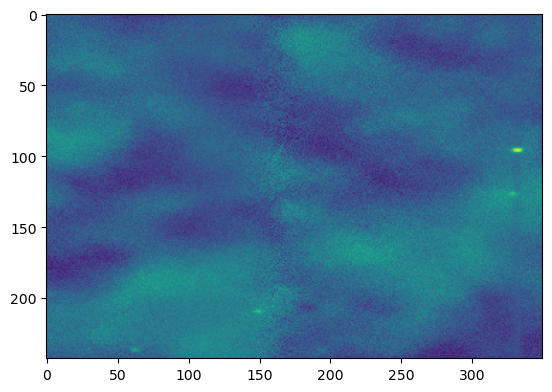

In [18]:
plt.imshow(img[1,...])

In [36]:
for j in range(10):

    img, truth = dataset_test[j]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    print(truth)
    print(prediction)
    print('\n')

{'boxes': tensor([[ 8., 13., 16., 21.]]), 'labels': tensor([1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor([1335]), 'area': tensor([64.]), 'iscrowd': tensor([0])}
[{'boxes': tensor([[ 7.0571, 13.0403, 14.9590, 21.0924],
        [ 7.9013, 15.2992, 15.5069, 23.4190]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7634, 0.0865], device='cuda:0')}]


{'boxes': tensor([[12., 16., 20., 24.]]), 'labels': tensor([1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor([3277]), 'area': tensor([64.]), 'iscrowd': te

{'boxes': tensor([[ 7.,  8., 15., 16.]]),
 'labels': tensor([1]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'image_id': tensor([3955]),
 'area': tensor([64.]),
 'iscrowd': tensor([0])}

[{'boxes': tensor([[ 7.3445,  7.8308, 15.2981, 15.9177]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9954], device='cuda:0')}]

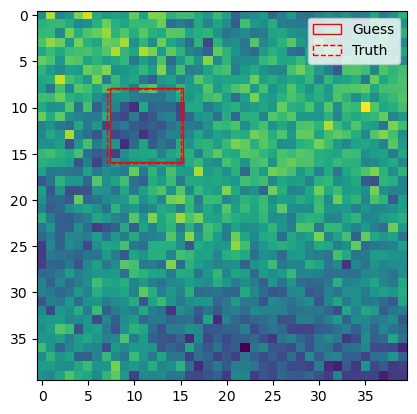

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(img[0,...])

colors = ["red", "black", "purple"]

for i in range(len(prediction[0]['boxes'])):
    if prediction[0]['scores'][i]>=0.5:
        xmin, ymin, xmax, ymax = prediction[0]['boxes'][i].cpu().numpy()
        rectangle = plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin, fc='none',ec=colors[i], label = 'Guess')
        ax.add_patch(rectangle)
        
for i in range(len(truth['boxes'])):
    xmin, ymin, xmax, ymax = truth['boxes'][i].cpu().numpy()
    rectangle = plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin, fc='none',ec=colors[i], linestyle = '--', label = 'Truth')
    ax.add_patch(rectangle)

plt.legend()
plt.savefig('./figs/region_prop_{}.png'.format(j))
plt.savefig('./figs/region_prop_{}.pdf'.format(j))

plt.show()
plt.close()

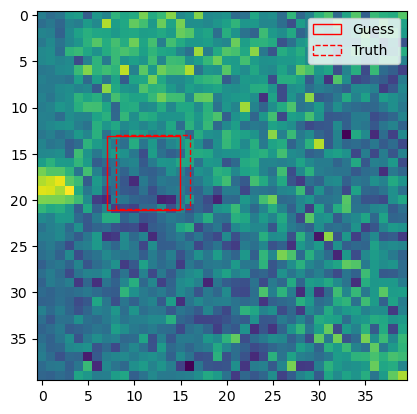

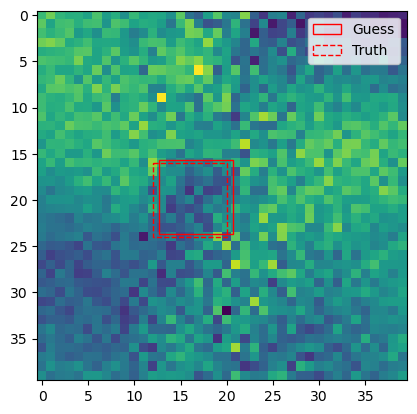

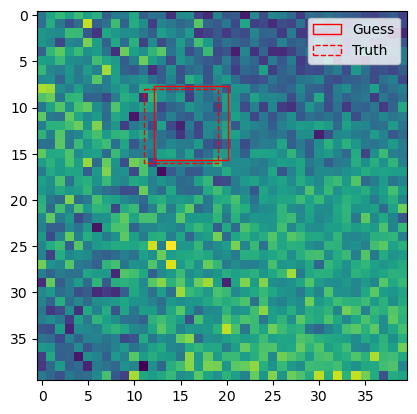

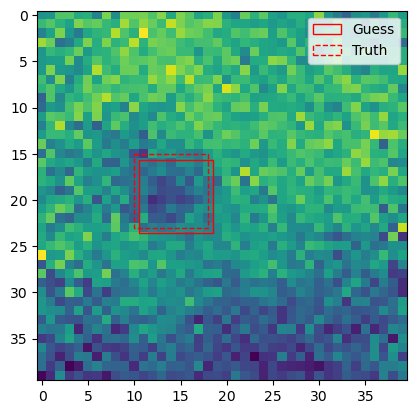

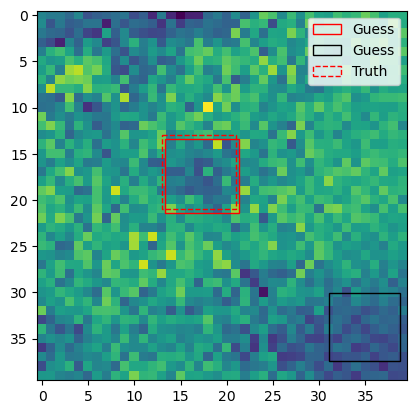

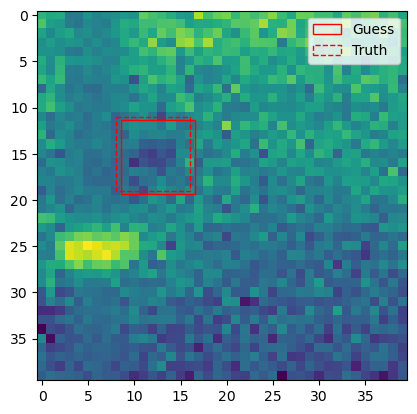

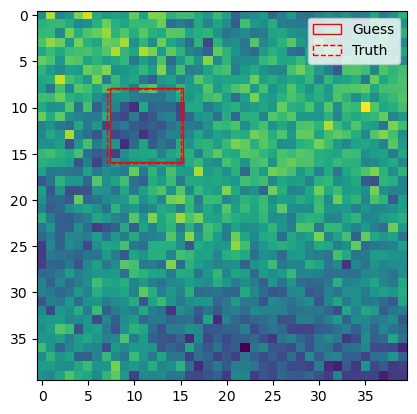

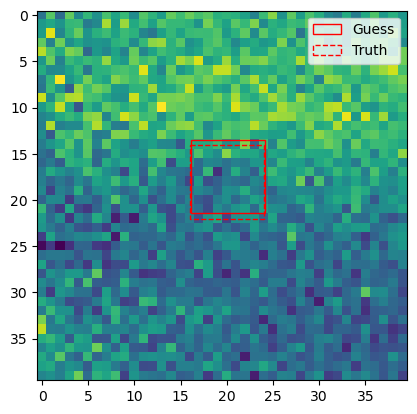

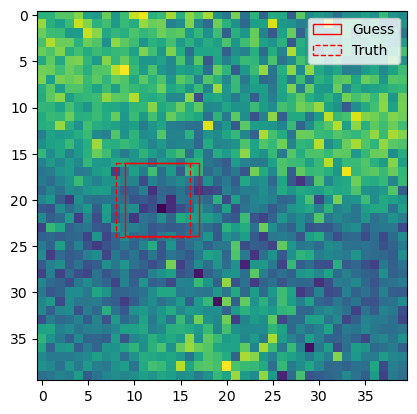

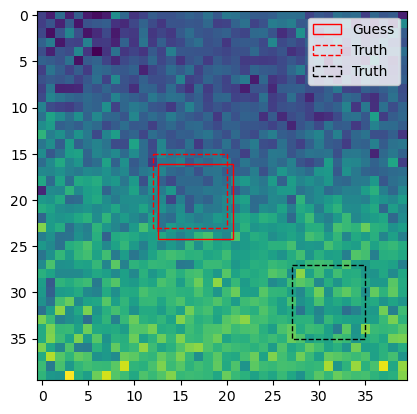

In [34]:
for j in range(10):
    img, truth = dataset_test[j]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.imshow(img[0,...])

    colors = ["red", "black", "purple"]

    for i in range(len(prediction[0]['boxes'])):
        if prediction[0]['scores'][i]>=0.5:
            xmin, ymin, xmax, ymax = prediction[0]['boxes'][i].cpu().numpy()
            rectangle = plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin, fc='none',ec=colors[i], label = 'Guess')
            ax.add_patch(rectangle)

    for i in range(len(truth['boxes'])):
        xmin, ymin, xmax, ymax = truth['boxes'][i].cpu().numpy()
        rectangle = plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin, fc='none',ec=colors[i], linestyle = '--', label = 'Truth')
        ax.add_patch(rectangle)

    plt.legend()
    plt.savefig('./figs/region_prop_{}.png'.format(j))
    plt.savefig('./figs/region_prop_{}.pdf'.format(j))

    plt.show()
    plt.close()

In [116]:
dataset.__getitem__(132)


IMG Path:  /project/r/rbond/jorlo/datasets/ACT_tiles/small_freq_tiles/1_10_28.npz
Mask Path:  /project/r/rbond/jorlo/datasets/ACT_tiles/small_masks/1_10_28_mask.npz


(tensor([[[ 0.5933,  0.9929,  0.8902,  ...,  1.1963,  0.7773,  1.2454],
          [ 0.5696,  0.4048,  1.1954,  ...,  1.4849,  1.0370,  1.1291],
          [ 1.0562,  1.0574,  1.2324,  ...,  1.1694,  1.1347,  1.3855],
          ...,
          [-0.4771, -0.9267, -0.9985,  ..., -0.6829, -0.5475, -0.6425],
          [-0.4370, -0.6745, -0.9915,  ..., -0.4297, -0.3369, -0.5847],
          [-0.5650, -0.5043, -0.5060,  ..., -0.6092, -0.9639, -0.4249]],
 
         [[ 1.0955,  1.4642,  1.0668,  ...,  0.9036,  1.2585,  1.3106],
          [ 1.0188,  1.5512,  1.2660,  ...,  1.1488,  1.3768,  1.4281],
          [ 1.4948,  0.9884,  1.3483,  ...,  1.4645,  1.3002,  1.4032],
          ...,
          [-0.6123, -0.6063, -0.4347,  ..., -0.6577, -0.6459, -0.6502],
          [-0.3058, -0.4114, -1.0795,  ..., -0.4335, -0.2591, -0.4517],
          [-0.5844, -0.5211, -0.7760,  ..., -0.5026, -0.5748, -0.7374]],
 
         [[ 0.5621,  0.1748,  2.0243,  ..., -0.0655,  0.5373,  1.0885],
          [ 0.5718,  0.8562,

In [57]:
len(dataset.imgs)

AttributeError: 'Subset' object has no attribute 'imgs'

In [113]:
len(dataset.masks)

13455

In [ ]:
prediction[0]['boxes'][0,0]

# WISE

In [7]:

root = '/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/'
len(list(sorted(os.listdir(os.path.join(root, "masks")))))

2103

In [8]:
# use our dataset and defined transformations
dataset = WiseDataset(root, get_transform(train=True))
dataset_test = WiseDataset(root, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=visionutils.utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=visionutils.utils.collate_fn)

In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_frcnn_model(num_classes, backbone_type = 'resnet', backbone_path = None)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [33]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

#model.load_state_dict(torch.load("/project/r/rbond/jorlo/ml-clusters/models/torch-act/wise-mobilenet-frcnn.pth"))

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    torch.save(model.state_dict(), "/project/r/rbond/jorlo/ml-clusters/models/torch-act/wise-mobilenet-frcnn.pth")


Epoch: [0]  [   0/1026]  eta: 0:05:33  lr: 0.000001  loss: 99.2414 (99.2414)  loss_classifier: 0.1897 (0.1897)  loss_box_reg: 0.2591 (0.2591)  loss_objectness: 98.4677 (98.4677)  loss_rpn_box_reg: 0.3249 (0.3249)  time: 0.3249  data: 0.1643  max mem: 7693
Epoch: [0]  [  10/1026]  eta: 0:02:31  lr: 0.000006  loss: 6.4406 (16.0462)  loss_classifier: 0.3289 (0.6369)  loss_box_reg: 2.2082 (3.9947)  loss_objectness: 2.0484 (10.7080)  loss_rpn_box_reg: 0.5870 (0.7066)  time: 0.1490  data: 0.0184  max mem: 7693
Epoch: [0]  [  20/1026]  eta: 0:02:20  lr: 0.000011  loss: 6.9059 (15.8698)  loss_classifier: 0.9580 (4.0176)  loss_box_reg: 3.1031 (4.3955)  loss_objectness: 1.9857 (6.8560)  loss_rpn_box_reg: 0.5538 (0.6006)  time: 0.1301  data: 0.0046  max mem: 7693
Epoch: [0]  [  30/1026]  eta: 0:02:16  lr: 0.000016  loss: 6.0961 (12.0814)  loss_classifier: 2.9767 (3.5788)  loss_box_reg: 1.5345 (3.1866)  loss_objectness: 0.7465 (4.7722)  loss_rpn_box_reg: 0.3611 (0.5438)  time: 0.1303  data: 0.0052

Epoch: [0]  [ 330/1026]  eta: 0:01:36  lr: 0.000166  loss: 0.1516 (1.3585)  loss_classifier: 0.0536 (0.4056)  loss_box_reg: 0.0953 (0.3851)  loss_objectness: 0.0014 (0.5047)  loss_rpn_box_reg: 0.0007 (0.0631)  time: 0.1411  data: 0.0055  max mem: 7693
Epoch: [0]  [ 340/1026]  eta: 0:01:35  lr: 0.000171  loss: 0.1418 (1.3230)  loss_classifier: 0.0491 (0.3953)  loss_box_reg: 0.0870 (0.3763)  loss_objectness: 0.0024 (0.4901)  loss_rpn_box_reg: 0.0007 (0.0613)  time: 0.1411  data: 0.0056  max mem: 7693
Epoch: [0]  [ 350/1026]  eta: 0:01:34  lr: 0.000176  loss: 0.1185 (1.2886)  loss_classifier: 0.0431 (0.3852)  loss_box_reg: 0.0674 (0.3675)  loss_objectness: 0.0033 (0.4762)  loss_rpn_box_reg: 0.0006 (0.0596)  time: 0.1404  data: 0.0057  max mem: 7693
Epoch: [0]  [ 360/1026]  eta: 0:01:32  lr: 0.000181  loss: 0.1115 (1.2561)  loss_classifier: 0.0425 (0.3757)  loss_box_reg: 0.0643 (0.3592)  loss_objectness: 0.0050 (0.4632)  loss_rpn_box_reg: 0.0006 (0.0579)  time: 0.1404  data: 0.0055  max me

Epoch: [0]  [ 660/1026]  eta: 0:00:51  lr: 0.000331  loss: 0.0797 (0.7438)  loss_classifier: 0.0193 (0.2237)  loss_box_reg: 0.0569 (0.2327)  loss_objectness: 0.0003 (0.2553)  loss_rpn_box_reg: 0.0006 (0.0320)  time: 0.1414  data: 0.0056  max mem: 7693
Epoch: [0]  [ 670/1026]  eta: 0:00:49  lr: 0.000336  loss: 0.0962 (0.7350)  loss_classifier: 0.0233 (0.2211)  loss_box_reg: 0.0609 (0.2306)  loss_objectness: 0.0013 (0.2517)  loss_rpn_box_reg: 0.0007 (0.0316)  time: 0.1416  data: 0.0055  max mem: 7693
Epoch: [0]  [ 680/1026]  eta: 0:00:48  lr: 0.000341  loss: 0.1409 (0.7262)  loss_classifier: 0.0394 (0.2186)  loss_box_reg: 0.0819 (0.2284)  loss_objectness: 0.0031 (0.2481)  loss_rpn_box_reg: 0.0007 (0.0311)  time: 0.1420  data: 0.0055  max mem: 7693
Epoch: [0]  [ 690/1026]  eta: 0:00:47  lr: 0.000346  loss: 0.1190 (0.7175)  loss_classifier: 0.0388 (0.2159)  loss_box_reg: 0.0772 (0.2263)  loss_objectness: 0.0034 (0.2446)  loss_rpn_box_reg: 0.0006 (0.0307)  time: 0.1427  data: 0.0056  max me

Epoch: [0]  [ 990/1026]  eta: 0:00:05  lr: 0.000496  loss: 0.1214 (0.5550)  loss_classifier: 0.0413 (0.1707)  loss_box_reg: 0.0750 (0.1868)  loss_objectness: 0.0039 (0.1754)  loss_rpn_box_reg: 0.0006 (0.0221)  time: 0.1424  data: 0.0057  max mem: 7693
Epoch: [0]  [1000/1026]  eta: 0:00:03  lr: 0.000500  loss: 0.0961 (0.5504)  loss_classifier: 0.0337 (0.1693)  loss_box_reg: 0.0619 (0.1856)  loss_objectness: 0.0016 (0.1737)  loss_rpn_box_reg: 0.0006 (0.0219)  time: 0.1432  data: 0.0056  max mem: 7693
Epoch: [0]  [1010/1026]  eta: 0:00:02  lr: 0.000500  loss: 0.0988 (0.5460)  loss_classifier: 0.0306 (0.1680)  loss_box_reg: 0.0612 (0.1844)  loss_objectness: 0.0023 (0.1720)  loss_rpn_box_reg: 0.0006 (0.0217)  time: 0.1439  data: 0.0056  max mem: 7693
Epoch: [0]  [1020/1026]  eta: 0:00:00  lr: 0.000500  loss: 0.1050 (0.5418)  loss_classifier: 0.0359 (0.1667)  loss_box_reg: 0.0675 (0.1833)  loss_objectness: 0.0025 (0.1703)  loss_rpn_box_reg: 0.0006 (0.0215)  time: 0.1436  data: 0.0056  max me

Epoch: [1]  [ 220/1026]  eta: 0:01:55  lr: 0.000500  loss: 0.0905 (0.0984)  loss_classifier: 0.0283 (0.0304)  loss_box_reg: 0.0570 (0.0639)  loss_objectness: 0.0017 (0.0036)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1426  data: 0.0053  max mem: 7693
Epoch: [1]  [ 230/1026]  eta: 0:01:54  lr: 0.000500  loss: 0.0866 (0.0978)  loss_classifier: 0.0249 (0.0301)  loss_box_reg: 0.0587 (0.0636)  loss_objectness: 0.0011 (0.0035)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1424  data: 0.0054  max mem: 7693
Epoch: [1]  [ 240/1026]  eta: 0:01:52  lr: 0.000500  loss: 0.0758 (0.0974)  loss_classifier: 0.0230 (0.0300)  loss_box_reg: 0.0514 (0.0633)  loss_objectness: 0.0012 (0.0035)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1428  data: 0.0058  max mem: 7693
Epoch: [1]  [ 250/1026]  eta: 0:01:51  lr: 0.000500  loss: 0.0812 (0.0973)  loss_classifier: 0.0237 (0.0299)  loss_box_reg: 0.0571 (0.0634)  loss_objectness: 0.0010 (0.0034)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1428  data: 0.0059  max me

Epoch: [1]  [ 550/1026]  eta: 0:01:07  lr: 0.000500  loss: 0.0885 (0.0953)  loss_classifier: 0.0228 (0.0288)  loss_box_reg: 0.0634 (0.0628)  loss_objectness: 0.0008 (0.0032)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1416  data: 0.0056  max mem: 7693
Epoch: [1]  [ 560/1026]  eta: 0:01:06  lr: 0.000500  loss: 0.0944 (0.0953)  loss_classifier: 0.0235 (0.0287)  loss_box_reg: 0.0624 (0.0628)  loss_objectness: 0.0008 (0.0032)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1414  data: 0.0056  max mem: 7693
Epoch: [1]  [ 570/1026]  eta: 0:01:05  lr: 0.000500  loss: 0.0930 (0.0953)  loss_classifier: 0.0235 (0.0287)  loss_box_reg: 0.0573 (0.0628)  loss_objectness: 0.0014 (0.0032)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1414  data: 0.0057  max mem: 7693
Epoch: [1]  [ 580/1026]  eta: 0:01:03  lr: 0.000500  loss: 0.0931 (0.0954)  loss_classifier: 0.0245 (0.0287)  loss_box_reg: 0.0641 (0.0630)  loss_objectness: 0.0019 (0.0032)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1419  data: 0.0057  max me

Epoch: [1]  [ 880/1026]  eta: 0:00:20  lr: 0.000500  loss: 0.0983 (0.0956)  loss_classifier: 0.0236 (0.0273)  loss_box_reg: 0.0730 (0.0647)  loss_objectness: 0.0015 (0.0031)  loss_rpn_box_reg: 0.0007 (0.0006)  time: 0.1427  data: 0.0056  max mem: 7693
Epoch: [1]  [ 890/1026]  eta: 0:00:19  lr: 0.000500  loss: 0.0965 (0.0958)  loss_classifier: 0.0232 (0.0273)  loss_box_reg: 0.0695 (0.0649)  loss_objectness: 0.0012 (0.0031)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1426  data: 0.0057  max mem: 7693
Epoch: [1]  [ 900/1026]  eta: 0:00:17  lr: 0.000500  loss: 0.0845 (0.0956)  loss_classifier: 0.0181 (0.0272)  loss_box_reg: 0.0600 (0.0648)  loss_objectness: 0.0014 (0.0031)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1422  data: 0.0057  max mem: 7693
Epoch: [1]  [ 910/1026]  eta: 0:00:16  lr: 0.000500  loss: 0.0735 (0.0956)  loss_classifier: 0.0195 (0.0272)  loss_box_reg: 0.0546 (0.0648)  loss_objectness: 0.0012 (0.0031)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1419  data: 0.0056  max me

Epoch: [2]  [ 110/1026]  eta: 0:02:11  lr: 0.000500  loss: 0.0704 (0.0800)  loss_classifier: 0.0202 (0.0206)  loss_box_reg: 0.0501 (0.0560)  loss_objectness: 0.0010 (0.0028)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1436  data: 0.0058  max mem: 7693
Epoch: [2]  [ 120/1026]  eta: 0:02:10  lr: 0.000500  loss: 0.0678 (0.0793)  loss_classifier: 0.0164 (0.0203)  loss_box_reg: 0.0490 (0.0555)  loss_objectness: 0.0006 (0.0029)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1436  data: 0.0058  max mem: 7693
Epoch: [2]  [ 130/1026]  eta: 0:02:09  lr: 0.000500  loss: 0.0704 (0.0793)  loss_classifier: 0.0164 (0.0203)  loss_box_reg: 0.0531 (0.0557)  loss_objectness: 0.0005 (0.0028)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1438  data: 0.0058  max mem: 7693
Epoch: [2]  [ 140/1026]  eta: 0:02:07  lr: 0.000500  loss: 0.0735 (0.0796)  loss_classifier: 0.0166 (0.0205)  loss_box_reg: 0.0516 (0.0558)  loss_objectness: 0.0006 (0.0028)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1434  data: 0.0058  max me

Epoch: [2]  [ 440/1026]  eta: 0:01:24  lr: 0.000500  loss: 0.0704 (0.0823)  loss_classifier: 0.0149 (0.0214)  loss_box_reg: 0.0568 (0.0581)  loss_objectness: 0.0003 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1430  data: 0.0058  max mem: 7693
Epoch: [2]  [ 450/1026]  eta: 0:01:22  lr: 0.000500  loss: 0.0742 (0.0824)  loss_classifier: 0.0165 (0.0214)  loss_box_reg: 0.0573 (0.0581)  loss_objectness: 0.0005 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1431  data: 0.0057  max mem: 7693
Epoch: [2]  [ 460/1026]  eta: 0:01:21  lr: 0.000500  loss: 0.0774 (0.0823)  loss_classifier: 0.0191 (0.0214)  loss_box_reg: 0.0553 (0.0581)  loss_objectness: 0.0006 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1430  data: 0.0057  max mem: 7693
Epoch: [2]  [ 470/1026]  eta: 0:01:19  lr: 0.000500  loss: 0.0776 (0.0824)  loss_classifier: 0.0187 (0.0214)  loss_box_reg: 0.0553 (0.0582)  loss_objectness: 0.0005 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1428  data: 0.0058  max me

Epoch: [2]  [ 770/1026]  eta: 0:00:36  lr: 0.000500  loss: 0.0804 (0.0808)  loss_classifier: 0.0191 (0.0205)  loss_box_reg: 0.0528 (0.0575)  loss_objectness: 0.0006 (0.0022)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1427  data: 0.0057  max mem: 7693
Epoch: [2]  [ 780/1026]  eta: 0:00:35  lr: 0.000500  loss: 0.0853 (0.0809)  loss_classifier: 0.0221 (0.0206)  loss_box_reg: 0.0576 (0.0575)  loss_objectness: 0.0016 (0.0022)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1433  data: 0.0057  max mem: 7693
Epoch: [2]  [ 790/1026]  eta: 0:00:33  lr: 0.000500  loss: 0.0841 (0.0810)  loss_classifier: 0.0221 (0.0206)  loss_box_reg: 0.0564 (0.0576)  loss_objectness: 0.0014 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1446  data: 0.0060  max mem: 7693
Epoch: [2]  [ 800/1026]  eta: 0:00:32  lr: 0.000500  loss: 0.0728 (0.0810)  loss_classifier: 0.0222 (0.0207)  loss_box_reg: 0.0462 (0.0575)  loss_objectness: 0.0011 (0.0022)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1450  data: 0.0062  max me

Epoch: [3]  [   0/1026]  eta: 0:04:50  lr: 0.000050  loss: 0.0885 (0.0885)  loss_classifier: 0.0205 (0.0205)  loss_box_reg: 0.0671 (0.0671)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.2835  data: 0.1353  max mem: 7693
Epoch: [3]  [  10/1026]  eta: 0:02:38  lr: 0.000050  loss: 0.0807 (0.0887)  loss_classifier: 0.0205 (0.0222)  loss_box_reg: 0.0620 (0.0628)  loss_objectness: 0.0010 (0.0031)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1558  data: 0.0171  max mem: 7693
Epoch: [3]  [  20/1026]  eta: 0:02:30  lr: 0.000050  loss: 0.0807 (0.0885)  loss_classifier: 0.0185 (0.0217)  loss_box_reg: 0.0612 (0.0632)  loss_objectness: 0.0010 (0.0030)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1429  data: 0.0053  max mem: 7693
Epoch: [3]  [  30/1026]  eta: 0:02:26  lr: 0.000050  loss: 0.0831 (0.0905)  loss_classifier: 0.0197 (0.0231)  loss_box_reg: 0.0562 (0.0643)  loss_objectness: 0.0008 (0.0025)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1429  data: 0.0053  max me

Epoch: [3]  [ 330/1026]  eta: 0:01:40  lr: 0.000050  loss: 0.0776 (0.0804)  loss_classifier: 0.0160 (0.0184)  loss_box_reg: 0.0566 (0.0594)  loss_objectness: 0.0005 (0.0020)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1445  data: 0.0059  max mem: 7693
Epoch: [3]  [ 340/1026]  eta: 0:01:38  lr: 0.000050  loss: 0.0634 (0.0798)  loss_classifier: 0.0130 (0.0183)  loss_box_reg: 0.0497 (0.0590)  loss_objectness: 0.0004 (0.0020)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1442  data: 0.0060  max mem: 7693
Epoch: [3]  [ 350/1026]  eta: 0:01:37  lr: 0.000050  loss: 0.0691 (0.0799)  loss_classifier: 0.0157 (0.0183)  loss_box_reg: 0.0525 (0.0592)  loss_objectness: 0.0003 (0.0019)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1442  data: 0.0060  max mem: 7693
Epoch: [3]  [ 360/1026]  eta: 0:01:35  lr: 0.000050  loss: 0.0744 (0.0797)  loss_classifier: 0.0169 (0.0181)  loss_box_reg: 0.0583 (0.0591)  loss_objectness: 0.0003 (0.0019)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1440  data: 0.0059  max me

Epoch: [3]  [ 660/1026]  eta: 0:00:52  lr: 0.000050  loss: 0.0746 (0.0772)  loss_classifier: 0.0181 (0.0177)  loss_box_reg: 0.0547 (0.0569)  loss_objectness: 0.0007 (0.0020)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1427  data: 0.0059  max mem: 7693
Epoch: [3]  [ 670/1026]  eta: 0:00:51  lr: 0.000050  loss: 0.0655 (0.0772)  loss_classifier: 0.0174 (0.0177)  loss_box_reg: 0.0510 (0.0569)  loss_objectness: 0.0008 (0.0020)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1424  data: 0.0058  max mem: 7693
Epoch: [3]  [ 680/1026]  eta: 0:00:49  lr: 0.000050  loss: 0.0692 (0.0772)  loss_classifier: 0.0176 (0.0177)  loss_box_reg: 0.0502 (0.0569)  loss_objectness: 0.0006 (0.0020)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1420  data: 0.0057  max mem: 7693
Epoch: [3]  [ 690/1026]  eta: 0:00:48  lr: 0.000050  loss: 0.0690 (0.0771)  loss_classifier: 0.0165 (0.0177)  loss_box_reg: 0.0491 (0.0568)  loss_objectness: 0.0006 (0.0020)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1421  data: 0.0057  max me

Epoch: [3]  [ 990/1026]  eta: 0:00:05  lr: 0.000050  loss: 0.0721 (0.0762)  loss_classifier: 0.0153 (0.0176)  loss_box_reg: 0.0499 (0.0559)  loss_objectness: 0.0004 (0.0021)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1421  data: 0.0057  max mem: 7693
Epoch: [3]  [1000/1026]  eta: 0:00:03  lr: 0.000050  loss: 0.0693 (0.0762)  loss_classifier: 0.0180 (0.0176)  loss_box_reg: 0.0503 (0.0559)  loss_objectness: 0.0006 (0.0021)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1420  data: 0.0056  max mem: 7693
Epoch: [3]  [1010/1026]  eta: 0:00:02  lr: 0.000050  loss: 0.0693 (0.0762)  loss_classifier: 0.0160 (0.0176)  loss_box_reg: 0.0549 (0.0559)  loss_objectness: 0.0004 (0.0021)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1420  data: 0.0056  max mem: 7693
Epoch: [3]  [1020/1026]  eta: 0:00:00  lr: 0.000050  loss: 0.0717 (0.0763)  loss_classifier: 0.0154 (0.0176)  loss_box_reg: 0.0549 (0.0560)  loss_objectness: 0.0004 (0.0021)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1419  data: 0.0057  max me

Epoch: [4]  [ 220/1026]  eta: 0:01:54  lr: 0.000050  loss: 0.0639 (0.0735)  loss_classifier: 0.0141 (0.0168)  loss_box_reg: 0.0486 (0.0540)  loss_objectness: 0.0005 (0.0022)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1418  data: 0.0053  max mem: 7693
Epoch: [4]  [ 230/1026]  eta: 0:01:53  lr: 0.000050  loss: 0.0648 (0.0735)  loss_classifier: 0.0150 (0.0168)  loss_box_reg: 0.0478 (0.0539)  loss_objectness: 0.0008 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1421  data: 0.0053  max mem: 7693
Epoch: [4]  [ 240/1026]  eta: 0:01:51  lr: 0.000050  loss: 0.0719 (0.0732)  loss_classifier: 0.0161 (0.0167)  loss_box_reg: 0.0478 (0.0537)  loss_objectness: 0.0008 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1420  data: 0.0053  max mem: 7693
Epoch: [4]  [ 250/1026]  eta: 0:01:50  lr: 0.000050  loss: 0.0729 (0.0736)  loss_classifier: 0.0172 (0.0168)  loss_box_reg: 0.0536 (0.0540)  loss_objectness: 0.0006 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1418  data: 0.0053  max me

Epoch: [4]  [ 550/1026]  eta: 0:01:07  lr: 0.000050  loss: 0.0691 (0.0734)  loss_classifier: 0.0169 (0.0167)  loss_box_reg: 0.0515 (0.0539)  loss_objectness: 0.0007 (0.0022)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1416  data: 0.0051  max mem: 7693
Epoch: [4]  [ 560/1026]  eta: 0:01:06  lr: 0.000050  loss: 0.0681 (0.0734)  loss_classifier: 0.0167 (0.0167)  loss_box_reg: 0.0514 (0.0539)  loss_objectness: 0.0008 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1417  data: 0.0051  max mem: 7693
Epoch: [4]  [ 570/1026]  eta: 0:01:04  lr: 0.000050  loss: 0.0681 (0.0735)  loss_classifier: 0.0183 (0.0168)  loss_box_reg: 0.0514 (0.0539)  loss_objectness: 0.0010 (0.0022)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1419  data: 0.0052  max mem: 7693
Epoch: [4]  [ 580/1026]  eta: 0:01:03  lr: 0.000050  loss: 0.0720 (0.0735)  loss_classifier: 0.0185 (0.0168)  loss_box_reg: 0.0508 (0.0539)  loss_objectness: 0.0007 (0.0022)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1418  data: 0.0053  max me

Epoch: [4]  [ 880/1026]  eta: 0:00:20  lr: 0.000050  loss: 0.0705 (0.0733)  loss_classifier: 0.0147 (0.0170)  loss_box_reg: 0.0504 (0.0535)  loss_objectness: 0.0005 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1418  data: 0.0052  max mem: 7693
Epoch: [4]  [ 890/1026]  eta: 0:00:19  lr: 0.000050  loss: 0.0680 (0.0733)  loss_classifier: 0.0179 (0.0170)  loss_box_reg: 0.0500 (0.0535)  loss_objectness: 0.0005 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1424  data: 0.0054  max mem: 7693
Epoch: [4]  [ 900/1026]  eta: 0:00:17  lr: 0.000050  loss: 0.0668 (0.0733)  loss_classifier: 0.0178 (0.0170)  loss_box_reg: 0.0500 (0.0535)  loss_objectness: 0.0007 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1436  data: 0.0059  max mem: 7693
Epoch: [4]  [ 910/1026]  eta: 0:00:16  lr: 0.000050  loss: 0.0659 (0.0734)  loss_classifier: 0.0155 (0.0170)  loss_box_reg: 0.0513 (0.0535)  loss_objectness: 0.0005 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1438  data: 0.0061  max me

Epoch: [5]  [ 110/1026]  eta: 0:02:10  lr: 0.000050  loss: 0.0720 (0.0742)  loss_classifier: 0.0151 (0.0170)  loss_box_reg: 0.0516 (0.0539)  loss_objectness: 0.0009 (0.0027)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1415  data: 0.0053  max mem: 7693
Epoch: [5]  [ 120/1026]  eta: 0:02:09  lr: 0.000050  loss: 0.0764 (0.0748)  loss_classifier: 0.0156 (0.0171)  loss_box_reg: 0.0555 (0.0543)  loss_objectness: 0.0011 (0.0028)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1413  data: 0.0052  max mem: 7693
Epoch: [5]  [ 130/1026]  eta: 0:02:07  lr: 0.000050  loss: 0.0681 (0.0743)  loss_classifier: 0.0149 (0.0169)  loss_box_reg: 0.0514 (0.0541)  loss_objectness: 0.0008 (0.0027)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1415  data: 0.0052  max mem: 7693
Epoch: [5]  [ 140/1026]  eta: 0:02:06  lr: 0.000050  loss: 0.0709 (0.0746)  loss_classifier: 0.0149 (0.0168)  loss_box_reg: 0.0520 (0.0544)  loss_objectness: 0.0008 (0.0028)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1416  data: 0.0052  max me

Epoch: [5]  [ 440/1026]  eta: 0:01:23  lr: 0.000050  loss: 0.0656 (0.0723)  loss_classifier: 0.0160 (0.0166)  loss_box_reg: 0.0498 (0.0526)  loss_objectness: 0.0008 (0.0025)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1419  data: 0.0052  max mem: 7693
Epoch: [5]  [ 450/1026]  eta: 0:01:21  lr: 0.000050  loss: 0.0632 (0.0723)  loss_classifier: 0.0149 (0.0166)  loss_box_reg: 0.0470 (0.0526)  loss_objectness: 0.0009 (0.0025)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1420  data: 0.0052  max mem: 7693
Epoch: [5]  [ 460/1026]  eta: 0:01:20  lr: 0.000050  loss: 0.0700 (0.0723)  loss_classifier: 0.0154 (0.0166)  loss_box_reg: 0.0517 (0.0526)  loss_objectness: 0.0007 (0.0025)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1419  data: 0.0053  max mem: 7693
Epoch: [5]  [ 470/1026]  eta: 0:01:18  lr: 0.000050  loss: 0.0700 (0.0722)  loss_classifier: 0.0161 (0.0166)  loss_box_reg: 0.0507 (0.0525)  loss_objectness: 0.0008 (0.0025)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1420  data: 0.0052  max me

Epoch: [5]  [ 770/1026]  eta: 0:00:36  lr: 0.000050  loss: 0.0700 (0.0712)  loss_classifier: 0.0160 (0.0163)  loss_box_reg: 0.0506 (0.0519)  loss_objectness: 0.0007 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1419  data: 0.0051  max mem: 7693
Epoch: [5]  [ 780/1026]  eta: 0:00:34  lr: 0.000050  loss: 0.0650 (0.0712)  loss_classifier: 0.0138 (0.0163)  loss_box_reg: 0.0508 (0.0519)  loss_objectness: 0.0007 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1419  data: 0.0052  max mem: 7693
Epoch: [5]  [ 790/1026]  eta: 0:00:33  lr: 0.000050  loss: 0.0615 (0.0711)  loss_classifier: 0.0129 (0.0162)  loss_box_reg: 0.0483 (0.0519)  loss_objectness: 0.0007 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1423  data: 0.0052  max mem: 7693
Epoch: [5]  [ 800/1026]  eta: 0:00:32  lr: 0.000050  loss: 0.0595 (0.0709)  loss_classifier: 0.0154 (0.0162)  loss_box_reg: 0.0459 (0.0518)  loss_objectness: 0.0005 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1421  data: 0.0051  max me

Epoch: [6]  [   0/1026]  eta: 0:04:44  lr: 0.000005  loss: 0.0628 (0.0628)  loss_classifier: 0.0153 (0.0153)  loss_box_reg: 0.0466 (0.0466)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.2770  data: 0.1293  max mem: 7693
Epoch: [6]  [  10/1026]  eta: 0:02:37  lr: 0.000005  loss: 0.0674 (0.0733)  loss_classifier: 0.0153 (0.0168)  loss_box_reg: 0.0555 (0.0551)  loss_objectness: 0.0006 (0.0007)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1551  data: 0.0166  max mem: 7693
Epoch: [6]  [  20/1026]  eta: 0:02:29  lr: 0.000005  loss: 0.0674 (0.0703)  loss_classifier: 0.0131 (0.0156)  loss_box_reg: 0.0505 (0.0524)  loss_objectness: 0.0007 (0.0018)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1426  data: 0.0053  max mem: 7693
Epoch: [6]  [  30/1026]  eta: 0:02:26  lr: 0.000005  loss: 0.0607 (0.0672)  loss_classifier: 0.0122 (0.0151)  loss_box_reg: 0.0460 (0.0502)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1422  data: 0.0052  max me

Epoch: [6]  [ 330/1026]  eta: 0:01:39  lr: 0.000005  loss: 0.0615 (0.0685)  loss_classifier: 0.0157 (0.0160)  loss_box_reg: 0.0471 (0.0495)  loss_objectness: 0.0009 (0.0025)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1433  data: 0.0055  max mem: 7693
Epoch: [6]  [ 340/1026]  eta: 0:01:38  lr: 0.000005  loss: 0.0770 (0.0690)  loss_classifier: 0.0171 (0.0161)  loss_box_reg: 0.0550 (0.0498)  loss_objectness: 0.0010 (0.0026)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1425  data: 0.0053  max mem: 7693
Epoch: [6]  [ 350/1026]  eta: 0:01:36  lr: 0.000005  loss: 0.0770 (0.0689)  loss_classifier: 0.0172 (0.0161)  loss_box_reg: 0.0517 (0.0497)  loss_objectness: 0.0012 (0.0026)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1426  data: 0.0052  max mem: 7693
Epoch: [6]  [ 360/1026]  eta: 0:01:35  lr: 0.000005  loss: 0.0624 (0.0689)  loss_classifier: 0.0142 (0.0161)  loss_box_reg: 0.0426 (0.0496)  loss_objectness: 0.0008 (0.0026)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1426  data: 0.0052  max me

Epoch: [6]  [ 660/1026]  eta: 0:00:52  lr: 0.000005  loss: 0.0621 (0.0684)  loss_classifier: 0.0144 (0.0159)  loss_box_reg: 0.0474 (0.0497)  loss_objectness: 0.0005 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1427  data: 0.0054  max mem: 7693
Epoch: [6]  [ 670/1026]  eta: 0:00:50  lr: 0.000005  loss: 0.0646 (0.0685)  loss_classifier: 0.0144 (0.0159)  loss_box_reg: 0.0474 (0.0497)  loss_objectness: 0.0006 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1426  data: 0.0054  max mem: 7693
Epoch: [6]  [ 680/1026]  eta: 0:00:49  lr: 0.000005  loss: 0.0645 (0.0685)  loss_classifier: 0.0129 (0.0159)  loss_box_reg: 0.0472 (0.0497)  loss_objectness: 0.0006 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1423  data: 0.0053  max mem: 7693
Epoch: [6]  [ 690/1026]  eta: 0:00:48  lr: 0.000005  loss: 0.0635 (0.0684)  loss_classifier: 0.0109 (0.0158)  loss_box_reg: 0.0494 (0.0497)  loss_objectness: 0.0005 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1426  data: 0.0055  max me

Epoch: [6]  [ 990/1026]  eta: 0:00:05  lr: 0.000005  loss: 0.0651 (0.0685)  loss_classifier: 0.0133 (0.0157)  loss_box_reg: 0.0514 (0.0499)  loss_objectness: 0.0004 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1423  data: 0.0052  max mem: 7693
Epoch: [6]  [1000/1026]  eta: 0:00:03  lr: 0.000005  loss: 0.0633 (0.0685)  loss_classifier: 0.0123 (0.0157)  loss_box_reg: 0.0502 (0.0499)  loss_objectness: 0.0004 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1424  data: 0.0052  max mem: 7693
Epoch: [6]  [1010/1026]  eta: 0:00:02  lr: 0.000005  loss: 0.0633 (0.0685)  loss_classifier: 0.0123 (0.0157)  loss_box_reg: 0.0464 (0.0499)  loss_objectness: 0.0008 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1425  data: 0.0052  max mem: 7693
Epoch: [6]  [1020/1026]  eta: 0:00:00  lr: 0.000005  loss: 0.0678 (0.0686)  loss_classifier: 0.0139 (0.0157)  loss_box_reg: 0.0480 (0.0499)  loss_objectness: 0.0008 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1424  data: 0.0053  max me

Epoch: [7]  [ 220/1026]  eta: 0:01:55  lr: 0.000005  loss: 0.0646 (0.0679)  loss_classifier: 0.0166 (0.0154)  loss_box_reg: 0.0489 (0.0494)  loss_objectness: 0.0005 (0.0025)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1429  data: 0.0055  max mem: 7693
Epoch: [7]  [ 230/1026]  eta: 0:01:54  lr: 0.000005  loss: 0.0670 (0.0680)  loss_classifier: 0.0153 (0.0154)  loss_box_reg: 0.0516 (0.0495)  loss_objectness: 0.0007 (0.0025)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1429  data: 0.0055  max mem: 7693
Epoch: [7]  [ 240/1026]  eta: 0:01:52  lr: 0.000005  loss: 0.0670 (0.0679)  loss_classifier: 0.0179 (0.0155)  loss_box_reg: 0.0498 (0.0494)  loss_objectness: 0.0009 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1430  data: 0.0053  max mem: 7693
Epoch: [7]  [ 250/1026]  eta: 0:01:51  lr: 0.000005  loss: 0.0645 (0.0677)  loss_classifier: 0.0170 (0.0155)  loss_box_reg: 0.0439 (0.0493)  loss_objectness: 0.0006 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1428  data: 0.0052  max me

Epoch: [7]  [ 550/1026]  eta: 0:01:08  lr: 0.000005  loss: 0.0672 (0.0687)  loss_classifier: 0.0131 (0.0159)  loss_box_reg: 0.0515 (0.0500)  loss_objectness: 0.0005 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1434  data: 0.0056  max mem: 7693
Epoch: [7]  [ 560/1026]  eta: 0:01:06  lr: 0.000005  loss: 0.0671 (0.0686)  loss_classifier: 0.0140 (0.0159)  loss_box_reg: 0.0499 (0.0499)  loss_objectness: 0.0004 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1433  data: 0.0057  max mem: 7693
Epoch: [7]  [ 570/1026]  eta: 0:01:05  lr: 0.000005  loss: 0.0629 (0.0686)  loss_classifier: 0.0143 (0.0159)  loss_box_reg: 0.0467 (0.0499)  loss_objectness: 0.0004 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1428  data: 0.0054  max mem: 7693
Epoch: [7]  [ 580/1026]  eta: 0:01:03  lr: 0.000005  loss: 0.0612 (0.0686)  loss_classifier: 0.0141 (0.0158)  loss_box_reg: 0.0466 (0.0499)  loss_objectness: 0.0003 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1430  data: 0.0054  max me

Epoch: [7]  [ 880/1026]  eta: 0:00:20  lr: 0.000005  loss: 0.0657 (0.0685)  loss_classifier: 0.0182 (0.0157)  loss_box_reg: 0.0499 (0.0498)  loss_objectness: 0.0009 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1435  data: 0.0056  max mem: 7693
Epoch: [7]  [ 890/1026]  eta: 0:00:19  lr: 0.000005  loss: 0.0651 (0.0685)  loss_classifier: 0.0177 (0.0157)  loss_box_reg: 0.0478 (0.0498)  loss_objectness: 0.0008 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1430  data: 0.0054  max mem: 7693
Epoch: [7]  [ 900/1026]  eta: 0:00:18  lr: 0.000005  loss: 0.0651 (0.0685)  loss_classifier: 0.0142 (0.0157)  loss_box_reg: 0.0511 (0.0498)  loss_objectness: 0.0006 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1427  data: 0.0054  max mem: 7693
Epoch: [7]  [ 910/1026]  eta: 0:00:16  lr: 0.000005  loss: 0.0638 (0.0685)  loss_classifier: 0.0102 (0.0157)  loss_box_reg: 0.0516 (0.0499)  loss_objectness: 0.0004 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1426  data: 0.0055  max me

Epoch: [8]  [ 110/1026]  eta: 0:02:11  lr: 0.000005  loss: 0.0633 (0.0683)  loss_classifier: 0.0149 (0.0159)  loss_box_reg: 0.0475 (0.0493)  loss_objectness: 0.0008 (0.0025)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1428  data: 0.0052  max mem: 7693
Epoch: [8]  [ 120/1026]  eta: 0:02:10  lr: 0.000005  loss: 0.0628 (0.0679)  loss_classifier: 0.0145 (0.0158)  loss_box_reg: 0.0476 (0.0490)  loss_objectness: 0.0009 (0.0026)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1425  data: 0.0052  max mem: 7693
Epoch: [8]  [ 130/1026]  eta: 0:02:08  lr: 0.000005  loss: 0.0610 (0.0677)  loss_classifier: 0.0133 (0.0157)  loss_box_reg: 0.0463 (0.0489)  loss_objectness: 0.0007 (0.0025)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1425  data: 0.0052  max mem: 7693
Epoch: [8]  [ 140/1026]  eta: 0:02:07  lr: 0.000005  loss: 0.0677 (0.0685)  loss_classifier: 0.0156 (0.0160)  loss_box_reg: 0.0478 (0.0494)  loss_objectness: 0.0008 (0.0026)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1425  data: 0.0053  max me

Epoch: [8]  [ 440/1026]  eta: 0:01:23  lr: 0.000005  loss: 0.0626 (0.0684)  loss_classifier: 0.0152 (0.0156)  loss_box_reg: 0.0450 (0.0499)  loss_objectness: 0.0006 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1426  data: 0.0053  max mem: 7693
Epoch: [8]  [ 450/1026]  eta: 0:01:22  lr: 0.000005  loss: 0.0661 (0.0685)  loss_classifier: 0.0150 (0.0156)  loss_box_reg: 0.0475 (0.0499)  loss_objectness: 0.0005 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1428  data: 0.0055  max mem: 7693
Epoch: [8]  [ 460/1026]  eta: 0:01:20  lr: 0.000005  loss: 0.0696 (0.0685)  loss_classifier: 0.0150 (0.0156)  loss_box_reg: 0.0500 (0.0499)  loss_objectness: 0.0005 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1426  data: 0.0055  max mem: 7693
Epoch: [8]  [ 470/1026]  eta: 0:01:19  lr: 0.000005  loss: 0.0646 (0.0684)  loss_classifier: 0.0156 (0.0156)  loss_box_reg: 0.0453 (0.0499)  loss_objectness: 0.0004 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1426  data: 0.0056  max me

Epoch: [8]  [ 770/1026]  eta: 0:00:36  lr: 0.000005  loss: 0.0603 (0.0688)  loss_classifier: 0.0147 (0.0158)  loss_box_reg: 0.0456 (0.0501)  loss_objectness: 0.0007 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1437  data: 0.0060  max mem: 7693
Epoch: [8]  [ 780/1026]  eta: 0:00:35  lr: 0.000005  loss: 0.0658 (0.0688)  loss_classifier: 0.0178 (0.0158)  loss_box_reg: 0.0448 (0.0501)  loss_objectness: 0.0008 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1429  data: 0.0056  max mem: 7693
Epoch: [8]  [ 790/1026]  eta: 0:00:33  lr: 0.000005  loss: 0.0689 (0.0689)  loss_classifier: 0.0156 (0.0158)  loss_box_reg: 0.0485 (0.0501)  loss_objectness: 0.0010 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1424  data: 0.0053  max mem: 7693
Epoch: [8]  [ 800/1026]  eta: 0:00:32  lr: 0.000005  loss: 0.0656 (0.0688)  loss_classifier: 0.0142 (0.0158)  loss_box_reg: 0.0485 (0.0501)  loss_objectness: 0.0009 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1423  data: 0.0052  max me

Epoch: [9]  [   0/1026]  eta: 0:04:55  lr: 0.000001  loss: 0.0749 (0.0749)  loss_classifier: 0.0165 (0.0165)  loss_box_reg: 0.0578 (0.0578)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.2885  data: 0.1427  max mem: 7693
Epoch: [9]  [  10/1026]  eta: 0:02:37  lr: 0.000001  loss: 0.0588 (0.0584)  loss_classifier: 0.0158 (0.0148)  loss_box_reg: 0.0422 (0.0425)  loss_objectness: 0.0007 (0.0006)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1551  data: 0.0170  max mem: 7693
Epoch: [9]  [  20/1026]  eta: 0:02:29  lr: 0.000001  loss: 0.0576 (0.0602)  loss_classifier: 0.0115 (0.0135)  loss_box_reg: 0.0422 (0.0445)  loss_objectness: 0.0006 (0.0017)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1419  data: 0.0048  max mem: 7693
Epoch: [9]  [  30/1026]  eta: 0:02:26  lr: 0.000001  loss: 0.0572 (0.0606)  loss_classifier: 0.0114 (0.0137)  loss_box_reg: 0.0440 (0.0447)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1421  data: 0.0052  max me

Epoch: [9]  [ 330/1026]  eta: 0:01:39  lr: 0.000001  loss: 0.0681 (0.0677)  loss_classifier: 0.0151 (0.0159)  loss_box_reg: 0.0488 (0.0493)  loss_objectness: 0.0007 (0.0018)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1425  data: 0.0053  max mem: 7693
Epoch: [9]  [ 340/1026]  eta: 0:01:37  lr: 0.000001  loss: 0.0651 (0.0680)  loss_classifier: 0.0142 (0.0160)  loss_box_reg: 0.0487 (0.0495)  loss_objectness: 0.0007 (0.0019)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1424  data: 0.0053  max mem: 7693
Epoch: [9]  [ 350/1026]  eta: 0:01:36  lr: 0.000001  loss: 0.0670 (0.0678)  loss_classifier: 0.0147 (0.0160)  loss_box_reg: 0.0487 (0.0494)  loss_objectness: 0.0007 (0.0019)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1423  data: 0.0052  max mem: 7693
Epoch: [9]  [ 360/1026]  eta: 0:01:34  lr: 0.000001  loss: 0.0615 (0.0677)  loss_classifier: 0.0147 (0.0160)  loss_box_reg: 0.0452 (0.0493)  loss_objectness: 0.0005 (0.0019)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1423  data: 0.0052  max me

Epoch: [9]  [ 660/1026]  eta: 0:00:52  lr: 0.000001  loss: 0.0642 (0.0675)  loss_classifier: 0.0152 (0.0159)  loss_box_reg: 0.0478 (0.0491)  loss_objectness: 0.0009 (0.0020)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1424  data: 0.0052  max mem: 7693
Epoch: [9]  [ 670/1026]  eta: 0:00:50  lr: 0.000001  loss: 0.0642 (0.0676)  loss_classifier: 0.0160 (0.0159)  loss_box_reg: 0.0481 (0.0491)  loss_objectness: 0.0006 (0.0020)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1419  data: 0.0052  max mem: 7693
Epoch: [9]  [ 680/1026]  eta: 0:00:49  lr: 0.000001  loss: 0.0730 (0.0677)  loss_classifier: 0.0160 (0.0159)  loss_box_reg: 0.0526 (0.0492)  loss_objectness: 0.0005 (0.0020)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1419  data: 0.0052  max mem: 7693
Epoch: [9]  [ 690/1026]  eta: 0:00:47  lr: 0.000001  loss: 0.0640 (0.0676)  loss_classifier: 0.0154 (0.0159)  loss_box_reg: 0.0463 (0.0492)  loss_objectness: 0.0005 (0.0020)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1421  data: 0.0053  max me

Epoch: [9]  [ 990/1026]  eta: 0:00:05  lr: 0.000001  loss: 0.0618 (0.0678)  loss_classifier: 0.0122 (0.0159)  loss_box_reg: 0.0452 (0.0495)  loss_objectness: 0.0007 (0.0019)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1426  data: 0.0052  max mem: 7693
Epoch: [9]  [1000/1026]  eta: 0:00:03  lr: 0.000001  loss: 0.0603 (0.0678)  loss_classifier: 0.0115 (0.0158)  loss_box_reg: 0.0422 (0.0495)  loss_objectness: 0.0007 (0.0019)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1428  data: 0.0052  max mem: 7693
Epoch: [9]  [1010/1026]  eta: 0:00:02  lr: 0.000001  loss: 0.0650 (0.0678)  loss_classifier: 0.0133 (0.0158)  loss_box_reg: 0.0475 (0.0495)  loss_objectness: 0.0005 (0.0019)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1427  data: 0.0055  max mem: 7693
Epoch: [9]  [1020/1026]  eta: 0:00:00  lr: 0.000001  loss: 0.0674 (0.0678)  loss_classifier: 0.0150 (0.0158)  loss_box_reg: 0.0465 (0.0495)  loss_objectness: 0.0004 (0.0019)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1427  data: 0.0057  max me

In [34]:
for j in range(455):
    mask_list = list(sorted(os.listdir(os.path.join('/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/', "masks"))))
    mask_path = os.path.join('/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/', "masks", mask_list[j])
    with np.load(mask_path) as data:
        mask = data['arr_0']
    # convert the PIL Image into a numpy array
    mask = np.array(mask)
    # instances are encoded as different colors
    obj_ids = np.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]
    # split the color-encoded mask into a set
    # of binary masks
    masks = mask == obj_ids[:, None, None]
    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])
        if xmin==xmax and ymin == ymax:
            print(mask_list[j])
        
        

    # convert everything into a torch.Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)

In [35]:
path = '/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/'

with np.load(path+'clusters/'+'cluster_0002.npz') as data:
        img = data['arr_0']
with np.load(path+'masks/'+'cluster_mask_0002.npz') as data:
        mask = data['arr_0']
img = np.array(img)
mask = np.array(mask)
# instances are encoded as different colors
obj_ids = np.unique(mask)
# first id is the background, so remove it
obj_ids = obj_ids[1:]
# split the color-encoded mask into a set
# of binary masks
masks = mask == obj_ids[:, None, None]
# get bounding box coordinates for each mask
num_objs = len(obj_ids)
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])

In [36]:
for j in range(10):
    img, truth = dataset_test[j]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    print(prediction)

[{'boxes': tensor([[ 74.2842, 125.5862, 204.4459, 183.2608],
        [ 80.7603, 117.5172, 183.0824, 219.2383],
        [ 92.7553,  81.5191, 195.0852, 183.2341],
        [ 76.2366,  79.3519, 152.1033, 230.1178],
        [128.7610, 117.5236, 231.0896, 219.2339],
        [110.3630,  97.8978, 243.7008, 165.4121]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8783, 0.8783, 0.8781, 0.8781, 0.8780, 0.1818], device='cuda:0')}]
[{'boxes': tensor([[135.6959, 126.3558, 227.3909, 207.5980],
        [105.0395, 127.8617, 207.0064, 230.1287],
        [ 95.2385, 114.4849, 197.3775, 194.4284],
        [ 81.0427,  79.8606, 183.0082, 182.1310],
        [117.0447,  79.8596, 219.0054, 182.1296],
        [ 73.9267,  74.8702, 233.4713, 224.2793],
        [ 83.0168, 127.5547, 166.9624, 220.4985]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8195, 0.8194, 0.8193, 0.8193, 0.8193, 0.8159, 0.2474],
       device='c

In [71]:
for i in range(50):
    img, truth = dataset_test[i]

    eval_img(img, truth, model)
    print('\n')

X loc:  (141.86311299165527, 0.3927302214658047)
Y loc:  (155.65838000608076, 0.3927302214658047)


X loc:  (156.26553880116296, 0.3342696986510036)
Y loc:  (151.99289529746292, 0.3342696986510036)


X loc:  (157.24004672562694, 0.4368900693299188)
Y loc:  (154.96239906380546, 0.4368900693299188)


X loc:  (151.10330654376594, 0.37165737337957777)
Y loc:  (152.37440480373664, 0.37165737337957777)


X loc:  (152.099527435763, 0.4810383220896894)
Y loc:  (155.4151800205781, 0.4810383220896894)


X loc:  (152.87415589642043, 0.44674187587968367)
Y loc:  (159.5989259007853, 0.44674187587968367)


X loc:  (139.9584268442431, 0.2925676942033946)
Y loc:  (154.16914640103107, 0.2925676942033946)


X loc:  (150.1313093982223, 0.4187017933914129)
Y loc:  (147.48527506079384, 0.4187017933914129)


X loc:  (153.9262961760077, 0.36424087730629356)
Y loc:  (153.6534402874581, 0.36424087730629356)


X loc:  (144.87860146259544, 0.3931146594110141)
Y loc:  (157.6700245089284, 0.3931146594110141)


X l

In [61]:
inv_var(ys, errs)

(155.65838000608076, 0.3927302214658047)

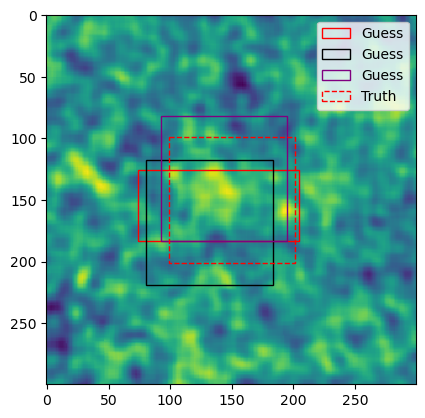

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(img[0,...])

colors = ["red", "black", "purple"]

for i in range(min(len(prediction[0]['boxes']), len(colors))):
    if prediction[0]['scores'][i]>=0.5:
        xmin, ymin, xmax, ymax = prediction[0]['boxes'][i].cpu().numpy()
        rectangle = plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin, fc='none',ec=colors[i], label = 'Guess')
        ax.add_patch(rectangle)
        
for i in range(len(truth['boxes'])):
    xmin, ymin, xmax, ymax = truth['boxes'][i].cpu().numpy()
    rectangle = plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin, fc='none',ec=colors[i], linestyle = '--', label = 'Truth')
    ax.add_patch(rectangle)

plt.legend()
#plt.savefig('./figs/region_prop_{}.png'.format(j))
#plt.savefig('./figs/region_prop_{}.pdf'.format(j))

plt.show()
plt.close()

# WISE w/ negs

In [8]:
root = '/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/'
len(list(sorted(os.listdir(os.path.join(root, "comb")))))

4259

In [9]:
# use our dataset and defined transformations
dataset = WiseDatasetNeg(root, get_transform(train=True))
dataset_test = WiseDatasetNeg(root, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=visionutils.utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=visionutils.utils.collate_fn)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_frcnn_model(num_classes, backbone_type = 'resnet', backbone_path = None)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /home/r/rbond/jorlo/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


  0%|          | 0.00/167M [00:00<?, ?B/s]

In [11]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 5

#model.load_state_dict(torch.load("/project/r/rbond/jorlo/ml-clusters/models/torch-act/wise-mobilenet-frcnn.pth"))

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    torch.save(model.state_dict(), "/project/r/rbond/jorlo/ml-clusters/models/torch-act/wise-mobilenet-frcnn.pth")

Epoch: [0]  [   0/2105]  eta: 18:28:04  lr: 0.000001  loss: 0.6288 (0.6288)  loss_classifier: 0.5239 (0.5239)  loss_box_reg: 0.0005 (0.0005)  loss_objectness: 0.1037 (0.1037)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 31.5841  data: 0.3142  max mem: 3111
Epoch: [0]  [  10/2105]  eta: 1:47:22  lr: 0.000006  loss: 0.6074 (0.6128)  loss_classifier: 0.5316 (0.5291)  loss_box_reg: 0.0191 (0.0175)  loss_objectness: 0.0466 (0.0645)  loss_rpn_box_reg: 0.0014 (0.0017)  time: 3.0752  data: 0.0366  max mem: 3442
Epoch: [0]  [  20/2105]  eta: 0:59:33  lr: 0.000011  loss: 0.6085 (0.6141)  loss_classifier: 0.5214 (0.5197)  loss_box_reg: 0.0212 (0.0214)  loss_objectness: 0.0529 (0.0711)  loss_rpn_box_reg: 0.0015 (0.0019)  time: 0.2202  data: 0.0067  max mem: 3442
Epoch: [0]  [  30/2105]  eta: 0:42:31  lr: 0.000016  loss: 0.5461 (0.5807)  loss_classifier: 0.4788 (0.4987)  loss_box_reg: 0.0140 (0.0174)  loss_objectness: 0.0458 (0.0630)  loss_rpn_box_reg: 0.0008 (0.0016)  time: 0.2148  data: 0.0040  max 

Epoch: [0]  [ 330/2105]  eta: 0:09:09  lr: 0.000166  loss: 0.0981 (0.1961)  loss_classifier: 0.0410 (0.1366)  loss_box_reg: 0.0394 (0.0302)  loss_objectness: 0.0068 (0.0282)  loss_rpn_box_reg: 0.0005 (0.0011)  time: 0.2151  data: 0.0039  max mem: 3442
Epoch: [0]  [ 340/2105]  eta: 0:09:01  lr: 0.000171  loss: 0.1100 (0.1943)  loss_classifier: 0.0530 (0.1344)  loss_box_reg: 0.0509 (0.0311)  loss_objectness: 0.0056 (0.0277)  loss_rpn_box_reg: 0.0009 (0.0011)  time: 0.2161  data: 0.0043  max mem: 3442
Epoch: [0]  [ 350/2105]  eta: 0:08:54  lr: 0.000176  loss: 0.1211 (0.1929)  loss_classifier: 0.0521 (0.1323)  loss_box_reg: 0.0589 (0.0324)  loss_objectness: 0.0056 (0.0272)  loss_rpn_box_reg: 0.0009 (0.0011)  time: 0.2164  data: 0.0044  max mem: 3442
Epoch: [0]  [ 360/2105]  eta: 0:08:46  lr: 0.000181  loss: 0.1192 (0.1906)  loss_classifier: 0.0450 (0.1298)  loss_box_reg: 0.0551 (0.0331)  loss_objectness: 0.0045 (0.0266)  loss_rpn_box_reg: 0.0006 (0.0011)  time: 0.2154  data: 0.0041  max me

Epoch: [0]  [ 660/2105]  eta: 0:06:19  lr: 0.000331  loss: 0.0707 (0.1455)  loss_classifier: 0.0253 (0.0867)  loss_box_reg: 0.0392 (0.0403)  loss_objectness: 0.0039 (0.0176)  loss_rpn_box_reg: 0.0003 (0.0009)  time: 0.2149  data: 0.0039  max mem: 3442
Epoch: [0]  [ 670/2105]  eta: 0:06:15  lr: 0.000336  loss: 0.0698 (0.1443)  loss_classifier: 0.0250 (0.0857)  loss_box_reg: 0.0392 (0.0402)  loss_objectness: 0.0041 (0.0175)  loss_rpn_box_reg: 0.0003 (0.0009)  time: 0.2150  data: 0.0039  max mem: 3442
Epoch: [0]  [ 680/2105]  eta: 0:06:12  lr: 0.000341  loss: 0.0760 (0.1435)  loss_classifier: 0.0248 (0.0849)  loss_box_reg: 0.0468 (0.0405)  loss_objectness: 0.0034 (0.0173)  loss_rpn_box_reg: 0.0006 (0.0009)  time: 0.2152  data: 0.0039  max mem: 3442
Epoch: [0]  [ 690/2105]  eta: 0:06:08  lr: 0.000346  loss: 0.0844 (0.1429)  loss_classifier: 0.0288 (0.0842)  loss_box_reg: 0.0572 (0.0407)  loss_objectness: 0.0029 (0.0171)  loss_rpn_box_reg: 0.0007 (0.0009)  time: 0.2162  data: 0.0042  max me

Epoch: [0]  [ 990/2105]  eta: 0:04:35  lr: 0.000496  loss: 0.1023 (0.1237)  loss_classifier: 0.0258 (0.0662)  loss_box_reg: 0.0744 (0.0436)  loss_objectness: 0.0013 (0.0131)  loss_rpn_box_reg: 0.0003 (0.0008)  time: 0.2160  data: 0.0041  max mem: 3442
Epoch: [0]  [1000/2105]  eta: 0:04:32  lr: 0.000500  loss: 0.1221 (0.1235)  loss_classifier: 0.0282 (0.0658)  loss_box_reg: 0.0820 (0.0439)  loss_objectness: 0.0021 (0.0130)  loss_rpn_box_reg: 0.0006 (0.0008)  time: 0.2167  data: 0.0044  max mem: 3442
Epoch: [0]  [1010/2105]  eta: 0:04:29  lr: 0.000500  loss: 0.0894 (0.1233)  loss_classifier: 0.0246 (0.0655)  loss_box_reg: 0.0630 (0.0442)  loss_objectness: 0.0017 (0.0129)  loss_rpn_box_reg: 0.0005 (0.0008)  time: 0.2161  data: 0.0043  max mem: 3442
Epoch: [0]  [1020/2105]  eta: 0:04:26  lr: 0.000500  loss: 0.0807 (0.1229)  loss_classifier: 0.0236 (0.0651)  loss_box_reg: 0.0554 (0.0442)  loss_objectness: 0.0014 (0.0128)  loss_rpn_box_reg: 0.0003 (0.0008)  time: 0.2157  data: 0.0040  max me

Epoch: [0]  [1320/2105]  eta: 0:03:07  lr: 0.000500  loss: 0.0645 (0.1135)  loss_classifier: 0.0186 (0.0558)  loss_box_reg: 0.0392 (0.0466)  loss_objectness: 0.0011 (0.0105)  loss_rpn_box_reg: 0.0003 (0.0007)  time: 0.2151  data: 0.0039  max mem: 3442
Epoch: [0]  [1330/2105]  eta: 0:03:05  lr: 0.000500  loss: 0.0645 (0.1132)  loss_classifier: 0.0188 (0.0555)  loss_box_reg: 0.0454 (0.0466)  loss_objectness: 0.0010 (0.0104)  loss_rpn_box_reg: 0.0003 (0.0007)  time: 0.2152  data: 0.0039  max mem: 3442
Epoch: [0]  [1340/2105]  eta: 0:03:02  lr: 0.000500  loss: 0.0761 (0.1130)  loss_classifier: 0.0209 (0.0553)  loss_box_reg: 0.0472 (0.0467)  loss_objectness: 0.0010 (0.0104)  loss_rpn_box_reg: 0.0003 (0.0007)  time: 0.2159  data: 0.0041  max mem: 3442
Epoch: [0]  [1350/2105]  eta: 0:03:00  lr: 0.000500  loss: 0.0781 (0.1128)  loss_classifier: 0.0222 (0.0551)  loss_box_reg: 0.0523 (0.0467)  loss_objectness: 0.0025 (0.0103)  loss_rpn_box_reg: 0.0003 (0.0007)  time: 0.2158  data: 0.0041  max me

Epoch: [0]  [1650/2105]  eta: 0:01:46  lr: 0.000500  loss: 0.0567 (0.1047)  loss_classifier: 0.0229 (0.0491)  loss_box_reg: 0.0351 (0.0462)  loss_objectness: 0.0009 (0.0088)  loss_rpn_box_reg: 0.0003 (0.0006)  time: 0.2152  data: 0.0038  max mem: 3442
Epoch: [0]  [1660/2105]  eta: 0:01:44  lr: 0.000500  loss: 0.0625 (0.1045)  loss_classifier: 0.0226 (0.0490)  loss_box_reg: 0.0352 (0.0461)  loss_objectness: 0.0009 (0.0088)  loss_rpn_box_reg: 0.0003 (0.0006)  time: 0.2154  data: 0.0040  max mem: 3442
Epoch: [0]  [1670/2105]  eta: 0:01:41  lr: 0.000500  loss: 0.0525 (0.1041)  loss_classifier: 0.0166 (0.0488)  loss_box_reg: 0.0322 (0.0460)  loss_objectness: 0.0009 (0.0087)  loss_rpn_box_reg: 0.0003 (0.0006)  time: 0.2145  data: 0.0037  max mem: 3442
Epoch: [0]  [1680/2105]  eta: 0:01:39  lr: 0.000500  loss: 0.0530 (0.1038)  loss_classifier: 0.0155 (0.0486)  loss_box_reg: 0.0322 (0.0459)  loss_objectness: 0.0009 (0.0087)  loss_rpn_box_reg: 0.0003 (0.0006)  time: 0.2147  data: 0.0037  max me

Epoch: [0]  [1980/2105]  eta: 0:00:28  lr: 0.000500  loss: 0.0570 (0.0974)  loss_classifier: 0.0200 (0.0446)  loss_box_reg: 0.0348 (0.0446)  loss_objectness: 0.0006 (0.0076)  loss_rpn_box_reg: 0.0003 (0.0006)  time: 0.2147  data: 0.0036  max mem: 3442
Epoch: [0]  [1990/2105]  eta: 0:00:26  lr: 0.000500  loss: 0.0603 (0.0972)  loss_classifier: 0.0206 (0.0445)  loss_box_reg: 0.0397 (0.0446)  loss_objectness: 0.0008 (0.0076)  loss_rpn_box_reg: 0.0003 (0.0006)  time: 0.2152  data: 0.0038  max mem: 3442
Epoch: [0]  [2000/2105]  eta: 0:00:24  lr: 0.000500  loss: 0.0623 (0.0971)  loss_classifier: 0.0207 (0.0444)  loss_box_reg: 0.0410 (0.0445)  loss_objectness: 0.0009 (0.0076)  loss_rpn_box_reg: 0.0003 (0.0006)  time: 0.2156  data: 0.0040  max mem: 3442
Epoch: [0]  [2010/2105]  eta: 0:00:21  lr: 0.000500  loss: 0.0576 (0.0969)  loss_classifier: 0.0206 (0.0443)  loss_box_reg: 0.0368 (0.0445)  loss_objectness: 0.0009 (0.0075)  loss_rpn_box_reg: 0.0003 (0.0006)  time: 0.2154  data: 0.0039  max me

Epoch: [1]  [ 130/2105]  eta: 0:07:06  lr: 0.000500  loss: 0.0570 (0.0587)  loss_classifier: 0.0211 (0.0210)  loss_box_reg: 0.0355 (0.0362)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2149  data: 0.0039  max mem: 3442
Epoch: [1]  [ 140/2105]  eta: 0:07:04  lr: 0.000500  loss: 0.0637 (0.0595)  loss_classifier: 0.0209 (0.0209)  loss_box_reg: 0.0379 (0.0370)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2159  data: 0.0042  max mem: 3442
Epoch: [1]  [ 150/2105]  eta: 0:07:01  lr: 0.000500  loss: 0.0645 (0.0605)  loss_classifier: 0.0216 (0.0210)  loss_box_reg: 0.0408 (0.0379)  loss_objectness: 0.0006 (0.0013)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2160  data: 0.0043  max mem: 3442
Epoch: [1]  [ 160/2105]  eta: 0:06:59  lr: 0.000500  loss: 0.0626 (0.0605)  loss_classifier: 0.0217 (0.0211)  loss_box_reg: 0.0409 (0.0378)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2154  data: 0.0040  max me

Epoch: [1]  [ 460/2105]  eta: 0:05:54  lr: 0.000500  loss: 0.0554 (0.0605)  loss_classifier: 0.0202 (0.0211)  loss_box_reg: 0.0322 (0.0377)  loss_objectness: 0.0006 (0.0014)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2148  data: 0.0038  max mem: 3442
Epoch: [1]  [ 470/2105]  eta: 0:05:52  lr: 0.000500  loss: 0.0500 (0.0602)  loss_classifier: 0.0174 (0.0210)  loss_box_reg: 0.0314 (0.0374)  loss_objectness: 0.0006 (0.0014)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2145  data: 0.0036  max mem: 3442
Epoch: [1]  [ 480/2105]  eta: 0:05:50  lr: 0.000500  loss: 0.0500 (0.0603)  loss_classifier: 0.0174 (0.0210)  loss_box_reg: 0.0326 (0.0376)  loss_objectness: 0.0006 (0.0014)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2152  data: 0.0039  max mem: 3442
Epoch: [1]  [ 490/2105]  eta: 0:05:48  lr: 0.000500  loss: 0.0598 (0.0604)  loss_classifier: 0.0185 (0.0210)  loss_box_reg: 0.0411 (0.0377)  loss_objectness: 0.0007 (0.0014)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2159  data: 0.0041  max me

Epoch: [1]  [ 790/2105]  eta: 0:04:43  lr: 0.000500  loss: 0.0464 (0.0583)  loss_classifier: 0.0169 (0.0206)  loss_box_reg: 0.0314 (0.0361)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2150  data: 0.0037  max mem: 3442
Epoch: [1]  [ 800/2105]  eta: 0:04:41  lr: 0.000500  loss: 0.0511 (0.0583)  loss_classifier: 0.0160 (0.0206)  loss_box_reg: 0.0341 (0.0361)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2155  data: 0.0039  max mem: 3442
Epoch: [1]  [ 810/2105]  eta: 0:04:39  lr: 0.000500  loss: 0.0492 (0.0581)  loss_classifier: 0.0166 (0.0205)  loss_box_reg: 0.0341 (0.0360)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2154  data: 0.0039  max mem: 3442
Epoch: [1]  [ 820/2105]  eta: 0:04:36  lr: 0.000500  loss: 0.0478 (0.0580)  loss_classifier: 0.0166 (0.0205)  loss_box_reg: 0.0305 (0.0359)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2151  data: 0.0038  max me

Epoch: [1]  [1120/2105]  eta: 0:03:32  lr: 0.000500  loss: 0.0576 (0.0583)  loss_classifier: 0.0217 (0.0203)  loss_box_reg: 0.0347 (0.0365)  loss_objectness: 0.0006 (0.0012)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2162  data: 0.0041  max mem: 3442
Epoch: [1]  [1130/2105]  eta: 0:03:30  lr: 0.000500  loss: 0.0521 (0.0583)  loss_classifier: 0.0190 (0.0203)  loss_box_reg: 0.0321 (0.0364)  loss_objectness: 0.0004 (0.0012)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2157  data: 0.0039  max mem: 3442
Epoch: [1]  [1140/2105]  eta: 0:03:28  lr: 0.000500  loss: 0.0529 (0.0583)  loss_classifier: 0.0196 (0.0203)  loss_box_reg: 0.0332 (0.0365)  loss_objectness: 0.0005 (0.0012)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2166  data: 0.0041  max mem: 3442
Epoch: [1]  [1150/2105]  eta: 0:03:25  lr: 0.000500  loss: 0.0658 (0.0583)  loss_classifier: 0.0205 (0.0203)  loss_box_reg: 0.0425 (0.0365)  loss_objectness: 0.0005 (0.0012)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2168  data: 0.0042  max me

Epoch: [1]  [1450/2105]  eta: 0:02:21  lr: 0.000500  loss: 0.0589 (0.0573)  loss_classifier: 0.0187 (0.0199)  loss_box_reg: 0.0416 (0.0359)  loss_objectness: 0.0005 (0.0012)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2167  data: 0.0044  max mem: 3442
Epoch: [1]  [1460/2105]  eta: 0:02:19  lr: 0.000500  loss: 0.0557 (0.0572)  loss_classifier: 0.0183 (0.0199)  loss_box_reg: 0.0363 (0.0359)  loss_objectness: 0.0006 (0.0012)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2161  data: 0.0042  max mem: 3442
Epoch: [1]  [1470/2105]  eta: 0:02:16  lr: 0.000500  loss: 0.0530 (0.0573)  loss_classifier: 0.0175 (0.0199)  loss_box_reg: 0.0337 (0.0359)  loss_objectness: 0.0006 (0.0012)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2159  data: 0.0041  max mem: 3442
Epoch: [1]  [1480/2105]  eta: 0:02:14  lr: 0.000500  loss: 0.0487 (0.0573)  loss_classifier: 0.0151 (0.0198)  loss_box_reg: 0.0335 (0.0359)  loss_objectness: 0.0005 (0.0012)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2161  data: 0.0041  max me

Epoch: [1]  [1780/2105]  eta: 0:01:10  lr: 0.000500  loss: 0.0503 (0.0565)  loss_classifier: 0.0159 (0.0194)  loss_box_reg: 0.0350 (0.0356)  loss_objectness: 0.0003 (0.0012)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2152  data: 0.0037  max mem: 3442
Epoch: [1]  [1790/2105]  eta: 0:01:07  lr: 0.000500  loss: 0.0529 (0.0565)  loss_classifier: 0.0158 (0.0194)  loss_box_reg: 0.0350 (0.0356)  loss_objectness: 0.0003 (0.0012)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2156  data: 0.0038  max mem: 3442
Epoch: [1]  [1800/2105]  eta: 0:01:05  lr: 0.000500  loss: 0.0506 (0.0565)  loss_classifier: 0.0159 (0.0194)  loss_box_reg: 0.0341 (0.0356)  loss_objectness: 0.0004 (0.0012)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2161  data: 0.0040  max mem: 3442
Epoch: [1]  [1810/2105]  eta: 0:01:03  lr: 0.000500  loss: 0.0516 (0.0564)  loss_classifier: 0.0181 (0.0194)  loss_box_reg: 0.0325 (0.0356)  loss_objectness: 0.0004 (0.0011)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2156  data: 0.0038  max me

Epoch: [1]  [2104/2105]  eta: 0:00:00  lr: 0.000500  loss: 0.0502 (0.0552)  loss_classifier: 0.0156 (0.0189)  loss_box_reg: 0.0343 (0.0349)  loss_objectness: 0.0006 (0.0011)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2109  data: 0.0045  max mem: 3442
Epoch: [1] Total time: 0:07:34 (0.2157 s / it)
creating index...
index created!
Test:  [ 0/50]  eta: 0:00:09  model_time: 0.0706 (0.0706)  evaluator_time: 0.0024 (0.0024)  time: 0.1940  data: 0.1199  max mem: 3442
Test:  [49/50]  eta: 0:00:00  model_time: 0.0558 (0.0565)  evaluator_time: 0.0003 (0.0006)  time: 0.0583  data: 0.0020  max mem: 3442
Test: Total time: 0:00:03 (0.0621 s / it)
Averaged stats: model_time: 0.0558 (0.0565)  evaluator_time: 0.0003 (0.0006)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   a

Epoch: [2]  [ 260/2105]  eta: 0:06:38  lr: 0.000500  loss: 0.0383 (0.0476)  loss_classifier: 0.0136 (0.0154)  loss_box_reg: 0.0271 (0.0311)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2147  data: 0.0040  max mem: 3442
Epoch: [2]  [ 270/2105]  eta: 0:06:35  lr: 0.000500  loss: 0.0493 (0.0482)  loss_classifier: 0.0145 (0.0155)  loss_box_reg: 0.0328 (0.0317)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2157  data: 0.0043  max mem: 3442
Epoch: [2]  [ 280/2105]  eta: 0:06:33  lr: 0.000500  loss: 0.0525 (0.0483)  loss_classifier: 0.0158 (0.0155)  loss_box_reg: 0.0340 (0.0317)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2161  data: 0.0045  max mem: 3442
Epoch: [2]  [ 290/2105]  eta: 0:06:31  lr: 0.000500  loss: 0.0500 (0.0481)  loss_classifier: 0.0154 (0.0154)  loss_box_reg: 0.0310 (0.0315)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2151  data: 0.0042  max me

Epoch: [2]  [ 590/2105]  eta: 0:05:26  lr: 0.000500  loss: 0.0419 (0.0467)  loss_classifier: 0.0108 (0.0148)  loss_box_reg: 0.0282 (0.0309)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2149  data: 0.0040  max mem: 3442
Epoch: [2]  [ 600/2105]  eta: 0:05:24  lr: 0.000500  loss: 0.0117 (0.0462)  loss_classifier: 0.0095 (0.0147)  loss_box_reg: 0.0000 (0.0305)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0000 (0.0003)  time: 0.2140  data: 0.0036  max mem: 3442
Epoch: [2]  [ 610/2105]  eta: 0:05:22  lr: 0.000500  loss: 0.0117 (0.0464)  loss_classifier: 0.0105 (0.0147)  loss_box_reg: 0.0000 (0.0307)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0000 (0.0003)  time: 0.2144  data: 0.0038  max mem: 3442
Epoch: [2]  [ 620/2105]  eta: 0:05:19  lr: 0.000500  loss: 0.0496 (0.0464)  loss_classifier: 0.0138 (0.0147)  loss_box_reg: 0.0349 (0.0306)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2156  data: 0.0043  max me

Epoch: [2]  [ 920/2105]  eta: 0:04:15  lr: 0.000500  loss: 0.0484 (0.0475)  loss_classifier: 0.0139 (0.0145)  loss_box_reg: 0.0311 (0.0320)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2152  data: 0.0041  max mem: 3442
Epoch: [2]  [ 930/2105]  eta: 0:04:13  lr: 0.000500  loss: 0.0517 (0.0477)  loss_classifier: 0.0143 (0.0145)  loss_box_reg: 0.0364 (0.0321)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2167  data: 0.0047  max mem: 3442
Epoch: [2]  [ 940/2105]  eta: 0:04:11  lr: 0.000500  loss: 0.0706 (0.0477)  loss_classifier: 0.0140 (0.0145)  loss_box_reg: 0.0529 (0.0322)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0005 (0.0003)  time: 0.2167  data: 0.0048  max mem: 3442
Epoch: [2]  [ 950/2105]  eta: 0:04:09  lr: 0.000500  loss: 0.0422 (0.0478)  loss_classifier: 0.0134 (0.0145)  loss_box_reg: 0.0329 (0.0323)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2161  data: 0.0046  max me

Epoch: [2]  [1250/2105]  eta: 0:03:04  lr: 0.000500  loss: 0.0375 (0.0474)  loss_classifier: 0.0105 (0.0140)  loss_box_reg: 0.0267 (0.0323)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2152  data: 0.0041  max mem: 3442
Epoch: [2]  [1260/2105]  eta: 0:03:02  lr: 0.000500  loss: 0.0391 (0.0474)  loss_classifier: 0.0110 (0.0140)  loss_box_reg: 0.0281 (0.0323)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2152  data: 0.0041  max mem: 3442
Epoch: [2]  [1270/2105]  eta: 0:03:00  lr: 0.000500  loss: 0.0443 (0.0473)  loss_classifier: 0.0134 (0.0140)  loss_box_reg: 0.0316 (0.0322)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2153  data: 0.0041  max mem: 3442
Epoch: [2]  [1280/2105]  eta: 0:02:57  lr: 0.000500  loss: 0.0443 (0.0474)  loss_classifier: 0.0107 (0.0140)  loss_box_reg: 0.0316 (0.0323)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2161  data: 0.0044  max me

Epoch: [2]  [1580/2105]  eta: 0:01:53  lr: 0.000500  loss: 0.0456 (0.0470)  loss_classifier: 0.0134 (0.0135)  loss_box_reg: 0.0305 (0.0324)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2157  data: 0.0044  max mem: 3442
Epoch: [2]  [1590/2105]  eta: 0:01:51  lr: 0.000500  loss: 0.0447 (0.0470)  loss_classifier: 0.0098 (0.0135)  loss_box_reg: 0.0305 (0.0324)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2153  data: 0.0041  max mem: 3442
Epoch: [2]  [1600/2105]  eta: 0:01:48  lr: 0.000500  loss: 0.0447 (0.0470)  loss_classifier: 0.0110 (0.0135)  loss_box_reg: 0.0318 (0.0324)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2159  data: 0.0044  max mem: 3442
Epoch: [2]  [1610/2105]  eta: 0:01:46  lr: 0.000500  loss: 0.0405 (0.0470)  loss_classifier: 0.0108 (0.0135)  loss_box_reg: 0.0302 (0.0324)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2155  data: 0.0043  max me

Epoch: [2]  [1910/2105]  eta: 0:00:42  lr: 0.000500  loss: 0.0413 (0.0464)  loss_classifier: 0.0117 (0.0131)  loss_box_reg: 0.0286 (0.0322)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2158  data: 0.0044  max mem: 3442
Epoch: [2]  [1920/2105]  eta: 0:00:39  lr: 0.000500  loss: 0.0572 (0.0464)  loss_classifier: 0.0142 (0.0131)  loss_box_reg: 0.0338 (0.0323)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2165  data: 0.0046  max mem: 3442
Epoch: [2]  [1930/2105]  eta: 0:00:37  lr: 0.000500  loss: 0.0540 (0.0464)  loss_classifier: 0.0151 (0.0131)  loss_box_reg: 0.0341 (0.0323)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2164  data: 0.0046  max mem: 3442
Epoch: [2]  [1940/2105]  eta: 0:00:35  lr: 0.000500  loss: 0.0485 (0.0465)  loss_classifier: 0.0118 (0.0131)  loss_box_reg: 0.0358 (0.0323)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2160  data: 0.0044  max me

Epoch: [3]  [  60/2105]  eta: 0:07:25  lr: 0.000050  loss: 0.0405 (0.0388)  loss_classifier: 0.0084 (0.0094)  loss_box_reg: 0.0273 (0.0279)  loss_objectness: 0.0003 (0.0013)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2146  data: 0.0038  max mem: 3442
Epoch: [3]  [  70/2105]  eta: 0:07:22  lr: 0.000050  loss: 0.0380 (0.0387)  loss_classifier: 0.0083 (0.0093)  loss_box_reg: 0.0273 (0.0280)  loss_objectness: 0.0002 (0.0011)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2145  data: 0.0038  max mem: 3442
Epoch: [3]  [  80/2105]  eta: 0:07:18  lr: 0.000050  loss: 0.0354 (0.0365)  loss_classifier: 0.0080 (0.0089)  loss_box_reg: 0.0268 (0.0262)  loss_objectness: 0.0002 (0.0011)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.2142  data: 0.0037  max mem: 3442
Epoch: [3]  [  90/2105]  eta: 0:07:16  lr: 0.000050  loss: 0.0354 (0.0361)  loss_classifier: 0.0072 (0.0087)  loss_box_reg: 0.0249 (0.0261)  loss_objectness: 0.0003 (0.0010)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.2145  data: 0.0036  max me

Epoch: [3]  [ 390/2105]  eta: 0:06:09  lr: 0.000050  loss: 0.0365 (0.0371)  loss_classifier: 0.0077 (0.0089)  loss_box_reg: 0.0262 (0.0271)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.2148  data: 0.0040  max mem: 3442
Epoch: [3]  [ 400/2105]  eta: 0:06:07  lr: 0.000050  loss: 0.0365 (0.0370)  loss_classifier: 0.0076 (0.0088)  loss_box_reg: 0.0272 (0.0270)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.2148  data: 0.0040  max mem: 3442
Epoch: [3]  [ 410/2105]  eta: 0:06:05  lr: 0.000050  loss: 0.0397 (0.0369)  loss_classifier: 0.0087 (0.0088)  loss_box_reg: 0.0314 (0.0270)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.2148  data: 0.0040  max mem: 3442
Epoch: [3]  [ 420/2105]  eta: 0:06:03  lr: 0.000050  loss: 0.0401 (0.0371)  loss_classifier: 0.0088 (0.0089)  loss_box_reg: 0.0314 (0.0271)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.2154  data: 0.0042  max me

Epoch: [3]  [ 720/2105]  eta: 0:04:58  lr: 0.000050  loss: 0.0415 (0.0404)  loss_classifier: 0.0086 (0.0092)  loss_box_reg: 0.0306 (0.0300)  loss_objectness: 0.0002 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2150  data: 0.0041  max mem: 3442
Epoch: [3]  [ 730/2105]  eta: 0:04:56  lr: 0.000050  loss: 0.0408 (0.0403)  loss_classifier: 0.0087 (0.0092)  loss_box_reg: 0.0318 (0.0299)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2159  data: 0.0045  max mem: 3442
Epoch: [3]  [ 740/2105]  eta: 0:04:54  lr: 0.000050  loss: 0.0354 (0.0402)  loss_classifier: 0.0073 (0.0091)  loss_box_reg: 0.0269 (0.0299)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2149  data: 0.0041  max mem: 3442
Epoch: [3]  [ 750/2105]  eta: 0:04:52  lr: 0.000050  loss: 0.0367 (0.0401)  loss_classifier: 0.0065 (0.0091)  loss_box_reg: 0.0273 (0.0298)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2147  data: 0.0040  max me

Epoch: [3]  [1050/2105]  eta: 0:03:47  lr: 0.000050  loss: 0.0359 (0.0401)  loss_classifier: 0.0084 (0.0092)  loss_box_reg: 0.0270 (0.0298)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2150  data: 0.0041  max mem: 3442
Epoch: [3]  [1060/2105]  eta: 0:03:45  lr: 0.000050  loss: 0.0376 (0.0400)  loss_classifier: 0.0081 (0.0092)  loss_box_reg: 0.0280 (0.0298)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2148  data: 0.0041  max mem: 3442
Epoch: [3]  [1070/2105]  eta: 0:03:43  lr: 0.000050  loss: 0.0411 (0.0402)  loss_classifier: 0.0082 (0.0092)  loss_box_reg: 0.0286 (0.0299)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2160  data: 0.0045  max mem: 3442
Epoch: [3]  [1080/2105]  eta: 0:03:41  lr: 0.000050  loss: 0.0368 (0.0401)  loss_classifier: 0.0078 (0.0092)  loss_box_reg: 0.0289 (0.0298)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2158  data: 0.0044  max me

Epoch: [3]  [1380/2105]  eta: 0:02:36  lr: 0.000050  loss: 0.0358 (0.0398)  loss_classifier: 0.0084 (0.0090)  loss_box_reg: 0.0291 (0.0296)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2155  data: 0.0042  max mem: 3442
Epoch: [3]  [1390/2105]  eta: 0:02:34  lr: 0.000050  loss: 0.0350 (0.0397)  loss_classifier: 0.0077 (0.0090)  loss_box_reg: 0.0269 (0.0296)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2152  data: 0.0042  max mem: 3442
Epoch: [3]  [1400/2105]  eta: 0:02:32  lr: 0.000050  loss: 0.0357 (0.0397)  loss_classifier: 0.0074 (0.0090)  loss_box_reg: 0.0267 (0.0296)  loss_objectness: 0.0002 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2154  data: 0.0042  max mem: 3442
Epoch: [3]  [1410/2105]  eta: 0:02:29  lr: 0.000050  loss: 0.0448 (0.0398)  loss_classifier: 0.0093 (0.0090)  loss_box_reg: 0.0372 (0.0297)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2161  data: 0.0046  max me

Epoch: [3]  [1710/2105]  eta: 0:01:25  lr: 0.000050  loss: 0.0364 (0.0402)  loss_classifier: 0.0078 (0.0090)  loss_box_reg: 0.0296 (0.0301)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2153  data: 0.0043  max mem: 3442
Epoch: [3]  [1720/2105]  eta: 0:01:23  lr: 0.000050  loss: 0.0377 (0.0402)  loss_classifier: 0.0068 (0.0090)  loss_box_reg: 0.0308 (0.0301)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2150  data: 0.0041  max mem: 3442
Epoch: [3]  [1730/2105]  eta: 0:01:20  lr: 0.000050  loss: 0.0418 (0.0402)  loss_classifier: 0.0082 (0.0090)  loss_box_reg: 0.0315 (0.0302)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2162  data: 0.0045  max mem: 3442
Epoch: [3]  [1740/2105]  eta: 0:01:18  lr: 0.000050  loss: 0.0425 (0.0403)  loss_classifier: 0.0093 (0.0090)  loss_box_reg: 0.0330 (0.0302)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2164  data: 0.0046  max me

Epoch: [3]  [2040/2105]  eta: 0:00:14  lr: 0.000050  loss: 0.0392 (0.0402)  loss_classifier: 0.0080 (0.0089)  loss_box_reg: 0.0306 (0.0302)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2158  data: 0.0044  max mem: 3442
Epoch: [3]  [2050/2105]  eta: 0:00:11  lr: 0.000050  loss: 0.0457 (0.0402)  loss_classifier: 0.0088 (0.0089)  loss_box_reg: 0.0287 (0.0302)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2162  data: 0.0045  max mem: 3442
Epoch: [3]  [2060/2105]  eta: 0:00:09  lr: 0.000050  loss: 0.0392 (0.0402)  loss_classifier: 0.0088 (0.0089)  loss_box_reg: 0.0286 (0.0302)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2158  data: 0.0044  max mem: 3442
Epoch: [3]  [2070/2105]  eta: 0:00:07  lr: 0.000050  loss: 0.0422 (0.0403)  loss_classifier: 0.0094 (0.0089)  loss_box_reg: 0.0329 (0.0303)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2164  data: 0.0047  max me

Epoch: [4]  [ 190/2105]  eta: 0:06:53  lr: 0.000050  loss: 0.0426 (0.0389)  loss_classifier: 0.0100 (0.0087)  loss_box_reg: 0.0296 (0.0291)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2153  data: 0.0040  max mem: 3442
Epoch: [4]  [ 200/2105]  eta: 0:06:51  lr: 0.000050  loss: 0.0461 (0.0391)  loss_classifier: 0.0109 (0.0088)  loss_box_reg: 0.0320 (0.0293)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2160  data: 0.0043  max mem: 3442
Epoch: [4]  [ 210/2105]  eta: 0:06:48  lr: 0.000050  loss: 0.0392 (0.0388)  loss_classifier: 0.0089 (0.0087)  loss_box_reg: 0.0286 (0.0291)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2155  data: 0.0040  max mem: 3442
Epoch: [4]  [ 220/2105]  eta: 0:06:46  lr: 0.000050  loss: 0.0392 (0.0392)  loss_classifier: 0.0090 (0.0087)  loss_box_reg: 0.0272 (0.0294)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2154  data: 0.0040  max me

Epoch: [4]  [ 520/2105]  eta: 0:05:42  lr: 0.000050  loss: 0.0377 (0.0412)  loss_classifier: 0.0089 (0.0089)  loss_box_reg: 0.0273 (0.0312)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2161  data: 0.0044  max mem: 3442
Epoch: [4]  [ 530/2105]  eta: 0:05:40  lr: 0.000050  loss: 0.0397 (0.0412)  loss_classifier: 0.0089 (0.0089)  loss_box_reg: 0.0276 (0.0312)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2160  data: 0.0044  max mem: 3442
Epoch: [4]  [ 540/2105]  eta: 0:05:38  lr: 0.000050  loss: 0.0372 (0.0412)  loss_classifier: 0.0080 (0.0089)  loss_box_reg: 0.0282 (0.0312)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2159  data: 0.0044  max mem: 3442
Epoch: [4]  [ 550/2105]  eta: 0:05:36  lr: 0.000050  loss: 0.0340 (0.0409)  loss_classifier: 0.0072 (0.0088)  loss_box_reg: 0.0255 (0.0310)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2152  data: 0.0041  max me

Epoch: [4]  [ 850/2105]  eta: 0:04:31  lr: 0.000050  loss: 0.0487 (0.0404)  loss_classifier: 0.0106 (0.0087)  loss_box_reg: 0.0372 (0.0306)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2169  data: 0.0048  max mem: 3442
Epoch: [4]  [ 860/2105]  eta: 0:04:28  lr: 0.000050  loss: 0.0387 (0.0404)  loss_classifier: 0.0087 (0.0087)  loss_box_reg: 0.0290 (0.0306)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2164  data: 0.0045  max mem: 3442
Epoch: [4]  [ 870/2105]  eta: 0:04:26  lr: 0.000050  loss: 0.0396 (0.0405)  loss_classifier: 0.0077 (0.0087)  loss_box_reg: 0.0284 (0.0306)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2163  data: 0.0045  max mem: 3442
Epoch: [4]  [ 880/2105]  eta: 0:04:24  lr: 0.000050  loss: 0.0381 (0.0403)  loss_classifier: 0.0071 (0.0087)  loss_box_reg: 0.0281 (0.0305)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2154  data: 0.0041  max me

Epoch: [4]  [1180/2105]  eta: 0:03:19  lr: 0.000050  loss: 0.0412 (0.0407)  loss_classifier: 0.0097 (0.0088)  loss_box_reg: 0.0315 (0.0308)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2165  data: 0.0045  max mem: 3442
Epoch: [4]  [1190/2105]  eta: 0:03:17  lr: 0.000050  loss: 0.0371 (0.0406)  loss_classifier: 0.0091 (0.0087)  loss_box_reg: 0.0274 (0.0307)  loss_objectness: 0.0004 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2166  data: 0.0046  max mem: 3442
Epoch: [4]  [1200/2105]  eta: 0:03:15  lr: 0.000050  loss: 0.0370 (0.0407)  loss_classifier: 0.0070 (0.0087)  loss_box_reg: 0.0274 (0.0308)  loss_objectness: 0.0004 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2157  data: 0.0043  max mem: 3442
Epoch: [4]  [1210/2105]  eta: 0:03:13  lr: 0.000050  loss: 0.0388 (0.0406)  loss_classifier: 0.0070 (0.0087)  loss_box_reg: 0.0314 (0.0307)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2158  data: 0.0042  max me

Epoch: [4]  [1510/2105]  eta: 0:02:08  lr: 0.000050  loss: 0.0394 (0.0403)  loss_classifier: 0.0084 (0.0086)  loss_box_reg: 0.0307 (0.0305)  loss_objectness: 0.0002 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2158  data: 0.0043  max mem: 3442
Epoch: [4]  [1520/2105]  eta: 0:02:06  lr: 0.000050  loss: 0.0357 (0.0403)  loss_classifier: 0.0080 (0.0086)  loss_box_reg: 0.0263 (0.0305)  loss_objectness: 0.0002 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2159  data: 0.0043  max mem: 3442
Epoch: [4]  [1530/2105]  eta: 0:02:04  lr: 0.000050  loss: 0.0360 (0.0403)  loss_classifier: 0.0080 (0.0086)  loss_box_reg: 0.0298 (0.0306)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2171  data: 0.0047  max mem: 3442
Epoch: [4]  [1540/2105]  eta: 0:02:02  lr: 0.000050  loss: 0.0358 (0.0402)  loss_classifier: 0.0069 (0.0086)  loss_box_reg: 0.0281 (0.0305)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2163  data: 0.0044  max me

Epoch: [4]  [1840/2105]  eta: 0:00:57  lr: 0.000050  loss: 0.0389 (0.0397)  loss_classifier: 0.0089 (0.0085)  loss_box_reg: 0.0300 (0.0301)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2168  data: 0.0046  max mem: 3442
Epoch: [4]  [1850/2105]  eta: 0:00:55  lr: 0.000050  loss: 0.0439 (0.0397)  loss_classifier: 0.0097 (0.0085)  loss_box_reg: 0.0294 (0.0301)  loss_objectness: 0.0005 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2169  data: 0.0047  max mem: 3442
Epoch: [4]  [1860/2105]  eta: 0:00:52  lr: 0.000050  loss: 0.0415 (0.0397)  loss_classifier: 0.0091 (0.0085)  loss_box_reg: 0.0285 (0.0301)  loss_objectness: 0.0004 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2164  data: 0.0045  max mem: 3442
Epoch: [4]  [1870/2105]  eta: 0:00:50  lr: 0.000050  loss: 0.0322 (0.0396)  loss_classifier: 0.0063 (0.0085)  loss_box_reg: 0.0236 (0.0300)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2154  data: 0.0040  max me

In [12]:
for j in range(10):
    img, truth = dataset_test[j]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    print("Truth: ", truth)
    print("Pred: ",prediction)

Truth:  {'boxes': tensor([[ 99.,  99., 201., 201.]]), 'labels': tensor([1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor([450]), 'area': tensor([10404.]), 'iscrowd': tensor([0])}
Pred:  [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Truth:  {'boxes': tensor([[ 99.,  99., 201., 201.]]), 'labels': tensor([1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor([255]), 'area': tensor([10404.]), 'iscrowd': tensor([0])}
Pred:  [{'boxes': tensor

In [13]:
for i in range(50):
    img, truth = dataset_test[i]

    eval_img(img, truth, model)
    print('\n')

ZeroDivisionError: division by zero

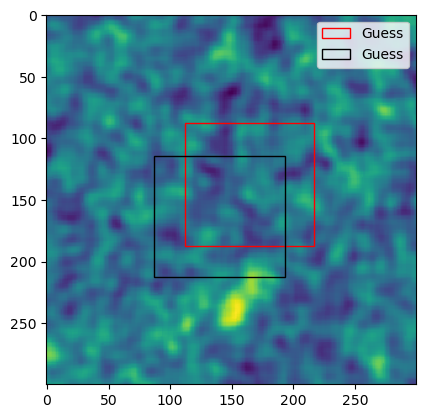

In [14]:
img, truth = dataset_test[6]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(img[0,...])

colors = ["red", "black", "purple"]

for i in range(min(len(prediction[0]['boxes']), len(colors))):
    if prediction[0]['scores'][i]>=0.7:
        xmin, ymin, xmax, ymax = prediction[0]['boxes'][i].cpu().numpy()
        rectangle = plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin, fc='none',ec=colors[i], label = 'Guess')
        ax.add_patch(rectangle)
        
for i in range(len(truth['boxes'])):
    xmin, ymin, xmax, ymax = truth['boxes'][i].cpu().numpy()
    rectangle = plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin, fc='none',ec=colors[i], linestyle = '--', label = 'Truth')
    ax.add_patch(rectangle)

plt.legend()
#plt.savefig('./figs/region_prop_{}.png'.format(j))
#plt.savefig('./figs/region_prop_{}.pdf'.format(j))

plt.show()
plt.close()

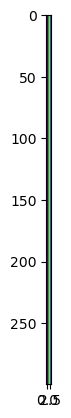

In [69]:
plt.imshow(img[0,...])

In [52]:
from astropy.io import fits

with np.load('/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/comb/randoms_1111.npz') as data:
    img = data['arr_0']
    img = np.array(img, dtype='f')

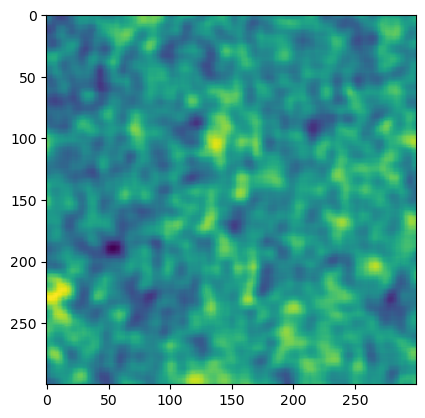

In [61]:
plt.imshow(img[...,3])

In [76]:
indices

[3208,
 904,
 3890,
 3051,
 1942,
 1386,
 3802,
 76,
 3244,
 3941,
 2345,
 1940,
 3867,
 1492,
 1167,
 839,
 4200,
 2498,
 1067,
 2055,
 539,
 2322,
 590,
 627,
 1202,
 1609,
 1224,
 303,
 2826,
 3453,
 4223,
 1163,
 3341,
 1220,
 3846,
 3092,
 1622,
 1727,
 4018,
 609,
 3287,
 340,
 2456,
 1978,
 2117,
 3728,
 1348,
 188,
 1465,
 1333,
 2912,
 52,
 1986,
 2267,
 1625,
 1346,
 2329,
 3945,
 2811,
 53,
 2300,
 1788,
 932,
 3401,
 657,
 1544,
 264,
 1318,
 3000,
 1767,
 466,
 394,
 1131,
 985,
 3186,
 603,
 3450,
 1628,
 215,
 1709,
 4232,
 3773,
 1879,
 3980,
 2009,
 4213,
 801,
 2346,
 160,
 3278,
 3136,
 2833,
 903,
 2066,
 1197,
 1025,
 3572,
 4040,
 4096,
 126,
 553,
 2608,
 2200,
 585,
 103,
 3145,
 844,
 1261,
 833,
 3984,
 3882,
 3390,
 1963,
 1550,
 1168,
 2479,
 2423,
 693,
 980,
 3119,
 2742,
 3698,
 1399,
 276,
 3588,
 382,
 1999,
 4059,
 984,
 1700,
 306,
 3625,
 3570,
 4220,
 3012,
 4221,
 593,
 3782,
 1611,
 3678,
 287,
 434,
 1705,
 3250,
 2279,
 67,
 3791,
 1441,
 3752,


In [ ]:
for j in range(455):
    mask_list = list(sorted(os.listdir(os.path.join('/project/r/rbond/jorlo/datasets/ACT_tiles/', "masks"))))
    mask_path = os.path.join('/project/r/rbond/jorlo/datasets/ACT_tiles/', "masks", mask_list[j])
    with np.load(mask_path) as data:
        mask = data['arr_0']
    # convert the PIL Image into a numpy array
    mask = np.array(mask)
    # instances are encoded as different colors
    obj_ids = np.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]
    # split the color-encoded mask into a set
    # of binary masks
    masks = mask == obj_ids[:, None, None]
    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])
        if xmin==xmax and ymin == ymax:
            print(mask_list[j])
        
        

    # convert everything into a torch.Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)